sigma_alpha = 10
eta_alpha = .3
sigma_z = 50
eta_z = 10
kappa = .5 #big enough
phi = 0.0001
b = .3
l = .5
alpha_I = 0.0001
psi = alpha_I + b/2
T = .7
N = 100
N_steps = 1_000
Batch_size = 100
kappa_z = 1
Number_size= 200
dt = T/N
rho = 0

def test():
    a= max(T**2,(9*phi**2+8*psi**2)/kappa**2)
    return(a<1,a,(9*phi**2+8*psi**2)/kappa**2)

print(test())

In [1]:
import torch
import torch.nn as nn
import matplotlib
matplotlib.use('Agg')  # backend sûr pour Jupyter
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline 
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [2]:
k = 1 #baseline k = 2
sigma_alpha = 5
eta_alpha = .3
sigma_z_tilde = 50 #50 #small:5 #50 baseline
eta_z_tilde= 10 #small:1 #10 baseline
kappa = .07 #.07 #benchmark was k=0.7, then for large b it was k=1
phi = 0. #0.001
b = 0.  #.03 new benchmark  # 0.3 (beta)
l = 0 #0.5 (beta^0)
beta_1 = 0.18 # 0.05 #(beta^1)
sigma_z = sigma_z_tilde*np.exp(-k*(l+b+beta_1))
eta_z = eta_z_tilde 
alpha_I = 0 # 0.001 #(ksi^I)
psi = alpha_I + b/2
T = .99
N = 100
N_steps = 101 #1001
Batch_size = 100 #100
kappa_z = 1
Number_size= 200
dt = T/N
rho = 0

In [1]:
torch.manual_seed(0)

NameError: name 'torch' is not defined

In [4]:
def test_2():
    a = max(T,(4*psi + 6*T*phi)/kappa)
    return (a<1,a)
print(test_2())

(True, 0.99)


!pip install torch

In [14]:
class ZNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64):
        super(ZNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, q_t,alpha_t,z_t):
        xy = torch.cat([q_t,alpha_t,z_t], dim=1)
        return self.net(xy)


In [15]:
def simulate_trajectory(Q0_I,Q0_U, Y0,Z_nets, 
                        b_QI,b_QU,b_Y, T, N, dW_S,dW_A,dW_Z):
    dt = T / N
    Q_I,Q_U, Y_I,Z_vals_S,Z_vals_A,Z_vals_Z,alpha,Z= [Q0_I],[Q0_U], [Y0],[],[],[], [torch.zeros(1, 1).expand(Q0_I.shape[0], -1)],[torch.zeros(1, 1).expand(Q0_I.shape[0], -1)]

    for i in range(N):
        t = i * dt
        q_I,q_U, y_I,Alpha_t,Z_t = Q_I[-1],Q_U[-1], Y_I[-1],alpha[-1],Z[-1]
        
        z_S = Z_nets[0][i](q_I,Alpha_t,Z_t)
        z_A = Z_nets[1][i](q_I,Alpha_t,Z_t)
        z_Z = Z_nets[2][i](q_I,Alpha_t,Z_t)
        
        Z_vals_S.append(z_S)
        Z_vals_A.append(z_A)
        Z_vals_Z.append(z_Z)
        
        dWt_S = dW_S[:, i, :]
        dWt_A = dW_A[:, i, :]
        dWt_Z = dW_Z[:, i, :]
        
        q_I_next = q_I + b_QI(l,q_U,y_I,Alpha_t) * dt 
        q_U_next = q_U + b_QU(Z_t) * dt
        
        y_I_next = y_I + b_Y(q_I,Alpha_t) * dt + z_S * dWt_S + z_A * dWt_A + z_Z*dWt_Z
        alpha_next = Alpha_t - eta_alpha * Alpha_t * dt + dWt_A*sigma_alpha
        z_next = Z_t - eta_z*Z_t*dt + dWt_Z*sigma_z
        
        alpha.append(alpha_next)
        Z.append(z_next)
        Q_I.append(q_I_next)
        Q_U.append(q_U_next)
        Y_I.append(y_I_next)    
        
    return Q_I,Q_U,Y_I,Z_vals_S,Z_vals_A,Z_vals_Z,alpha,Z


In [16]:
def compute_loss(Y_I_T,Q_I_T):
    target_I = -2*psi*Q_I_T
    return torch.mean((Y_I_T - target_I) ** 2)


In [17]:
def train(Z_nets, Y0_I, Q0_I, Q0_U, b_QI, b_QU, b_Y,T, N, num_steps=N_steps, batch_size=Batch_size):
    optimizer = torch.optim.Adam(
        [{'params': net.parameters()} for net_list in Z_nets for net in net_list] + [{'params': [Y0_I]}], 
        lr=1e-3
    )

    for step in range(num_steps):
        dW_S = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_A = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_Z = dW_S*rho + np.sqrt(1-rho**2)*torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5


        Q_I_list,Q_U_list, Y_I_list,_,_,_,_,_ = simulate_trajectory(
            Q0_I.expand(batch_size, -1), Q0_U.expand(batch_size,-1), Y0_I.expand(batch_size, -1),
            Z_nets, b_QI,b_QU,b_Y, T, N, dW_S,dW_A,dW_Z
        )
        loss = compute_loss(Y_I_list[-1], Q_I_list[-1],)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.5f}")

    return dW_S,dW_A,dW_Z
            

In [18]:
def b_QI(l,q_U,y_I,Alpha_t):
    c = -l-b*q_U + y_I - beta_1*Alpha_t
    tilde_c = -l+b*q_U - y_I + beta_1*Alpha_t

    left = torch.where(
        c > 0,
       c/(2*kappa),
        torch.zeros_like(c)
    )
    right = torch.where(
        tilde_c > 0,
        tilde_c/(2*kappa),
        torch.zeros_like(tilde_c)
    )
    return left - right

def b_QU(Z_t):
    return kappa_z*Z_t

def b_Y(q_I, alpha):
    return 2 * phi * q_I - alpha


In [19]:
dim_q_I = 1
dim_q_U = 1
dim_y = 1
input_dim = dim_q_I + dim_q_U + dim_y

Z_nets = [
    [ZNet(input_dim=input_dim) for _ in range(N)]  
    for _ in range(3)
]

Q0_I = torch.zeros(1, dim_q_I)
Q0_U = torch.zeros(1, dim_q_U)
Y0_I = nn.Parameter(torch.zeros(1, dim_y))

dW_S, dW_A,dW_Z = train(Z_nets, Y0_I, Q0_I, Q0_U, b_QI, b_QU, b_Y,T, N)

Step 0, Loss: 11.02386
Step 100, Loss: 2.17236


In [20]:
def plot_trajectory(Q_I, Q_U, Y_I, Z, alpha, dW_S, T, N, idx=0, number_size=Number_size):

    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    # Récupération des valeurs pour un élément spécifique du batch
    Q_I_vals = [Q_I[t][idx].item() for t in range(N+1)]
    Q_U_vals = [Q_U[t][idx].item() for t in range(N+1)]
    Y_I_vals = [Y_I[t][idx].item() for t in range(N+1)]
    alpha_vals = [alpha[t][idx].item() for t in range(N+1)]
    Z_vals = [Z[t][idx].item() for t in range(N+1)]

    alpha_values = [alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha for t in range(N+1)]

    # Calcul des différentes variables
    true_nu_plus, true_nu_minus = [], []
    nu_plus, nu_minus = [], []
    delta_plus, delta_minus = [], []
    delta_plus_fake,delta_minus_fake = [],[]
    tilde_delta_plus, tilde_delta_minus = [], []
    c, tilde_c = [], []

    for t in range(N+1):
        delta_plus.append(l + b*Q_U_vals[t] + b*Q_I_vals[t] +beta_1*alpha_vals[t])
        delta_minus.append(l - b*Q_U_vals[t] - b*Q_I_vals[t] - beta_1*alpha_vals[t])
        
        delta_plus_fake.append(l + b*Q_U_vals[t] + b*Q_I_vals[t])
        delta_minus_fake.append(l - b*Q_U_vals[t] - b*Q_I_vals[t])
        
        tilde_delta_plus.append(l + b*Q_U_vals[t])
        tilde_delta_minus.append(l - b*Q_U_vals[t])
        c.append(-delta_plus[t] + Y_I_vals[t])
        tilde_c.append(-delta_minus[t] - Y_I_vals[t])

        true_nu_plus.append(max((-l + alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa), 0))
        true_nu_minus.append(max((-l - alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa), 0))
        nu_plus.append(max(c[t]/(2*kappa), 0))
        nu_minus.append(max(tilde_c[t]/(2*kappa), 0))

    # Calcul du prix S_t
    S_t = [100]
    for t in range(N):
        S_t.append(S_t[t] + alpha_vals[t]*(T/N) + dW_S[idx,t,:].item())

    # Création d'une figure unique avec 6 sous-plots
    fig, axes = plt.subplots(6, 1, figsize=(14, 30), sharex=True)

    # 1️⃣ Trajectoires trading speed
    axes[0].plot(time_grid, nu_plus, label="nu_t^+", color='blue')
    axes[0].plot(time_grid, nu_minus, label="nu_t^-", color='red')
    axes[0].plot(time_grid, true_nu_plus, '--', label="tilde_nu_t^+", color='blue')
    axes[0].plot(time_grid, true_nu_minus, '--', label="tilde_nu_t^-", color='red')
    axes[0].set_title("Trajectoire de trading speed / only alpha signal")
    axes[0].legend()

    # 2️⃣ Z
    axes[1].plot(time_grid, Z_vals, label='Z_t')
    axes[1].set_title("Trajectoire de trading speed uninf / signal")
    axes[1].legend()

    # 3️⃣ alpha
    axes[2].plot(time_grid, alpha_vals, label='alpha_t')
    axes[2].set_title("Trajectoire du signal")
    axes[2].legend()

    # 4️⃣ Bid/ask price
    axes[3].plot(time_grid, S_t, label='S_t')
    axes[3].plot(time_grid, np.array(S_t) + np.array(delta_plus), label='S_t^+')
    axes[3].plot(time_grid, np.array(S_t) - np.array(delta_minus), label='S_t^-')
    
    axes[3].plot(time_grid, np.array(S_t) - np.array(delta_minus_fake), '--',label='S_t^{b^1=0,-}')
    axes[3].plot(time_grid, np.array(S_t) + np.array(delta_plus_fake), '--',label='S_t^{b^1=0,+}')

    axes[3].set_title("Bid/Ask price")
    axes[3].legend()

    # 5️⃣ Y vs alpha rescaled
    axes[4].plot(time_grid, alpha_values, label='alpha_t')
    axes[4].plot(time_grid, Y_I_vals, label="Y_t")
    axes[4].set_title("Y_t vs alpha_t rescaled")
    axes[4].legend()

    # 6️⃣ Inventory Q
    axes[5].plot(time_grid, Q_I_vals, label="Q_t^I", color='blue')
    axes[5].plot(time_grid, Q_U_vals, label="Q_t^U", color='orange')
    axes[5].plot(time_grid, (-1)*np.array(Q_I_vals) + (-1)*np.array(Q_U_vals), '--', label="Q_t^M", color='black')
    axes[5].set_title("Trajectoire de l'inventaire")
    axes[5].legend()

    plt.xlabel("Temps")
    plt.tight_layout()
    plt.savefig("figures_Stackelberg/traj.pdf")
    
    

def plot_after_training(number_size=Number_size):

# Génération des bruits aléatoires pour le batch
    dW_S = torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A = torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_Z = rho * dW_S + np.sqrt(1 - rho**2) * torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5

    # Simulation de trajectoires
    Q_I, Q_U, Y_I, _, _, _, alpha, Z = simulate_trajectory(
        Q0_I.expand(number_size, -1), 
        Q0_U.expand(number_size, -1), 
        Y0_I.expand(number_size, -1), 
        Z_nets, b_QI, b_QU, b_Y, 
        T, N,
        dW_S, dW_A, dW_Z
    )

    # Affichage des courbes pour le premier élément du batch (idx=0 par exemple)
    idx_to_plot = 10
    plot_trajectory(Q_I, Q_U, Y_I, Z, alpha, dW_S, T, N, idx=idx_to_plot, number_size=number_size)

plot_after_training()


def plot_trajectory(Q_I, Q_U, Y_I, Z, alpha, dW_S, T, N, idx=0,number_size=Number_size):
    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    # Récupération des valeurs pour un élément spécifique du batch
    Q_I_vals = [Q_I[t][idx].item() for t in range(N+1)]
    Q_U_vals = [Q_U[t][idx].item() for t in range(N+1)]
    Y_I_vals = [Y_I[t][idx].item() for t in range(N+1)]
    alpha_vals = [alpha[t][idx].item() for t in range(N+1)]
    Z_vals = [Z[t][idx].item() for t in range(N+1)]
    
    
    alpha_values=[]
    for t in range(N+1):
        alpha_values.append(alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)
        
    true_nu_plus = []
    true_nu_minus=[]
    tilde_delta_plus = []
    tilde_delta_minus = []
    delta_plus = []
    delta_minus = []
    c=[]
    tilde_c =[]
    for t in range(N+1):
        delta_plus.append(l+b*Q_U_vals[t]+b*Q_I_vals[t])
        delta_minus.append(l-b*Q_U_vals[t]-b*Q_I_vals[t])

        tilde_delta_plus.append(l+b*Q_U_vals[t])
        tilde_delta_minus.append(l-b*Q_U_vals[t])

        c.append(-tilde_delta_plus[t]+Y_I_vals[t])
        tilde_c.append(-tilde_delta_minus[t]-Y_I_vals[t])
        

    nu_plus = []
    nu_minus = []
   
    for t in range(N+1):
        if -l+alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha > 0:
            true_nu_plus.append((-l+alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa))
        else:
            true_nu_plus.append(0)
            
    for t in range(N+1):
        if -l-alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha > 0:
            true_nu_minus.append((-l-alpha_vals[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa))
        else:
            true_nu_minus.append(0)


    for t in range(N+1):
        if c[t] <= 0:
            nu_plus.append(0)
        else:
            nu_plus.append(c[t]/(2*kappa))
    
    for t in range(N+1):
        if tilde_c[t] <= 0:
            nu_minus.append(0)
        else:
            nu_minus.append(tilde_c[t]/(2*kappa))
    
    S_t = [100]
    for t in range(N):
        S_t.append(S_t[t] + alpha_vals[t]*(T / N) + dW_S[idx,t,:])
        #if error: dW_S[idx,t,0]
            
    
    # Tracer les courbes pour Q_I, Q_M, Y_I, Y_M
    plt.figure(figsize=(12, 6))

    # Trajectoire pour Q_I et Q_M
    plt.plot(time_grid, nu_plus, label="nu_t^+", color='blue')
    plt.plot(time_grid, nu_minus, label="nu_t^-", color='red')
    plt.plot(time_grid, true_nu_plus, '--',label="tilde_nu_t^+", color='blue')
    plt.plot(time_grid, true_nu_minus,'--',label="tilde_nu_t^-", color='red')
    plt.title("Trajectoire de trading speed / only alpha signal")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.savefig("test.png")
    
       plt.plot(time_grid,Z_vals,label='Z_t')
    plt.title("Trajectoire de trading speed uninf / signal")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
        
    plt.plot(time_grid,alpha_vals,label='alpha_t')
    plt.title("Trajectoire du signal")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    plt.plot(time_grid,S_t,label='S_t')
    plt.plot(time_grid,np.array(S_t) + np.array(delta_plus),label='S_t^+')
    plt.plot(time_grid,np.array(S_t) - np.array(delta_minus),label='S_t^-')
    plt.title("bid/ask price")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()

    
    
    plt.plot(time_grid,alpha_values,label='alpha_t')
    plt.plot(time_grid,Y_I_vals,label="Y_t")
    plt.title("Y_t vs alpha_t rescaled")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_grid, Q_I_vals, label="Q_t^I", color='blue')
    plt.plot(time_grid, Q_U_vals, label="Q_t^U", color='orange')
    plt.plot(time_grid, (-1)*np.array(Q_I_vals) + (-1)*np.array(Q_U_vals),'--', label="Q_t^M", color='black')
    plt.title("Trajectoire de inventory")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(time_grid, delta_plus, label="\delta_t^+", color='blue')
    plt.plot(time_grid, delta_minus, label="delta_t^-", color='red')
    plt.plot(time_grid,np.array([l for k in range(len(delta_plus))]),'--', label="delta_cst", color="orange")
    plt.title("Trajectoire quotes")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
def plot_after_training(number_size=Number_size):
    dW_S =  torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A =  torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_Z = rho*dW_S + np.sqrt(1-rho**2)* torch.randn(number_size, N, Y0_I.shape[1]) * (T / N) ** 0.5

    Q_I, Q_U, Y_I, _, _,_, alpha,Z = simulate_trajectory(
        Q0_I.expand(number_size, -1), Q0_U.expand(number_size, -1), Y0_I.expand(number_size, -1), Z_nets, b_QI, b_QU, b_Y, T, N,
   dW_S,dW_A,dW_Z)
    
    # Affichage des courbes pour le premier élément du batch

    plot_trajectory(Q_I, Q_U, Y_I, Z,alpha, dW_S,T, N,idx=100,number_size=Number_size)

# Appeler la fonction pour afficher les courbes après l'entraînement
plot_after_training()


In [21]:
def PnL(eps_bench,c_bench,nb_it ,a_bench = .5,b_bench = .5):
    time_grid = [i * T / N for i in range(N+1)]
    S0 =  torch.tensor([[100]])
    dW_S =  torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A =  torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_Z =  rho*dW_S + np.sqrt(1-rho**2)*torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    Q_I, Q_U, Y_I, _, _,_, alpha,Z = simulate_trajectory(
        Q0_I.expand(nb_it, -1), Q0_U.expand(nb_it, -1), Y0_I.expand(nb_it, -1), Z_nets, b_QI, b_QU, b_Y, T, N,
   dW_S,dW_A,dW_Z)
    X =  Q0_I.expand(nb_it, -1)
    S =  S0.expand(nb_it, -1)
    Q_bench = torch.zeros(1, dim_q_I).expand(nb_it,-1)
    Q_tot = Q0_U.expand(nb_it, -1)
    X_U =  Q0_I.expand(nb_it, -1)
    X_U_bench = Q0_U.expand(nb_it,-1)
    Q_tot_U_bench = Q0_I.expand(nb_it,-1)
    Q_tot_U = Q0_U.expand(nb_it, -1)
    Q_U_bench = Q0_U.expand(nb_it,-1)
    X_bench = Q_bench.expand(nb_it, -1)
    Q_tot_bench= Q_bench.expand(nb_it, -1)
    
    X_wth_del = Q0_I.expand(nb_it,-1)
    Q_wth_del = Q0_I.expand(nb_it,-1)
    Q_wth_del_tot = Q0_I.expand(nb_it,-1)
    
    Q_U_tilde = Q0_U.expand(nb_it,-1)
    
    Q_I_tilde = Q0_I.expand(nb_it,-1)
    X_I_tilde = Q0_I.expand(nb_it,-1)
    Q_I_tot_tilde = Q0_I.expand(nb_it,-1)
    ####
    Z_tilde = [Q0_I.expand(nb_it,-1)]
    ## MM:
    Q_tot_M = Q0_I.expand(nb_it,-1)
    ###
    spread = Q0_I.expand(nb_it,-1)
    trading_speed = Q0_I.expand(nb_it,-1)
    
    for t in range(N):
        Z_t_tilde = Z_tilde[-1]
        z_next = Z_t_tilde - eta_z*Z_t_tilde*dt + rho*sigma_z*dW_S[:,t,:]
        Z_tilde.append(z_next)

    
    
    for t in range(N):
        delta_plus = l+b*Q_U[t]+b*Q_I[t] + beta_1*alpha[t]
        delta_moins = l-b*Q_U[t]-b*Q_I[t] - beta_1*alpha[t]
        
        delta_plus_tilde = l+b*Q_U[t]+b*Q_I_tilde + beta_1*alpha[t]
        delta_moins_tilde = l-b*Q_U[t]-b*Q_I_tilde - beta_1*alpha[t]
        
        delta_plus_wth_del = l+b*Q_U[t]+b*Q_wth_del + beta_1*alpha[t]
        delta_moins_wth_del = l-b*Q_U[t]-b*Q_wth_del - beta_1*alpha[t]
        
        delta_plus_bench = l+b*Q_U[t]+b*Q_bench + beta_1*alpha[t]
        delta_moins_bench = l-b*Q_U[t]-b*Q_bench - beta_1*alpha[t]
        
        c = -l-b*Q_U[t] + Y_I[t] - beta_1*alpha[t]
        tilde_c = -l+b*Q_U[t] - Y_I[t] + beta_1*alpha[t]
        
        c_tilde = -l-b*Q_U_tilde + Y_I[t]
        tilde_c_tilde = -l+b*Q_U_tilde - Y_I[t] 
        
        
        c_wth = (-l+alpha[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa) - beta_1*alpha[t]/(2*kappa)
        tilde_c_wth = (-l-alpha[t]*(1-np.exp(-eta_alpha*(T-time_grid[t])))/eta_alpha)/(2*kappa) + beta_1*alpha[t]/(2*kappa)
        
        
        nu_plus_bench = torch.where((a_bench*alpha[t]-b_bench*Q_bench>eps_bench)*(delta_plus_bench<c_bench),a_bench*alpha[t]-b_bench*Q_bench,torch.zeros_like(a_bench*alpha[t]-b_bench*Q_bench))
        nu_minus_bench = torch.where((a_bench*alpha[t]-b_bench*Q_bench<-eps_bench)*(delta_moins_bench<c_bench),-a_bench*alpha[t]+b_bench*Q_bench,torch.zeros_like(a_bench*alpha[t]-b_bench*Q_bench))

        nu_plus = torch.where(c > 0, c/(2*kappa),torch.zeros_like(c))
        nu_minus = torch.where(tilde_c > 0, tilde_c/(2*kappa),torch.zeros_like(tilde_c)) 
        
        nu_plus_tilde = torch.where(c_tilde > 0, c_tilde/(2*kappa),torch.zeros_like(c_tilde))
        nu_minus_tilde = torch.where(tilde_c_tilde > 0, tilde_c_tilde/(2*kappa),torch.zeros_like(tilde_c_tilde))
        
        
        nu_plus_wth_del = torch.where(c_wth > 0, c_wth,torch.zeros_like(c_wth))
        nu_minus_wth_del = torch.where(tilde_c_wth > 0, tilde_c_wth,torch.zeros_like(tilde_c_wth))
        
        
        ##
        trading_speed = trading_speed + dt*(nu_plus + nu_minus)
        spread = spread + dt * (delta_plus + delta_moins)
        ##
        
        X_bench = X_bench + (S-delta_moins_bench - kappa*nu_minus_bench)*nu_minus_bench*dt - (S+delta_plus_bench+kappa*nu_plus_bench)*nu_plus_bench*dt
        X = X + (S-delta_moins - kappa*nu_minus)*nu_minus*dt - (S+delta_plus+kappa*nu_plus)*nu_plus*dt
        X_U = X_U + (S-delta_moins - kappa*torch.where(Z[t] < 0, -Z[t],torch.zeros_like(Z[t])))*torch.where(Z[t] < 0, -Z[t],torch.zeros_like(Z[t]))*dt - (S+delta_plus+kappa*torch.where(Z[t] > 0, Z[t],torch.zeros_like(Z[t])))*torch.where(Z[t] > 0, Z[t],torch.zeros_like(Z[t]))*dt
        X_U_bench = X_U_bench + (S-delta_moins_bench - kappa*torch.where(Z[t] < 0, -Z[t],torch.zeros_like(Z[t])))*torch.where(Z[t] < 0, -Z[t],torch.zeros_like(Z[t]))*dt - (S+delta_plus_bench+kappa*torch.where(Z[t] > 0, Z[t],torch.zeros_like(Z[t])))*torch.where(Z[t] > 0, Z[t],torch.zeros_like(Z[t]))*dt
        X_wth_del = X_wth_del + (S-delta_moins_wth_del - kappa*nu_minus_wth_del)*nu_minus_wth_del*dt - (S+delta_plus_wth_del+kappa*nu_plus_wth_del)*nu_plus_wth_del*dt
        X_I_tilde = X_I_tilde + (S-delta_moins_tilde - kappa*nu_minus_tilde)*nu_minus_tilde*dt - (S+delta_plus_tilde+kappa*nu_plus_tilde)*nu_plus_tilde*dt

        
        S = S +alpha[t]*dt + dW_S[:,t,:]
        
        Q_wth_del_tot = Q_wth_del_tot + Q_wth_del**2*dt
        Q_wth_del = Q_wth_del + (nu_plus_wth_del-nu_minus_wth_del)*dt
        #Q_tot_U_bench = Q_tot_U_bench + Q_U_bench**2*dt, useless
        
        Q_tot_bench = Q_tot_bench + Q_bench**2*dt
        Q_bench = Q_bench + (nu_plus_bench - nu_minus_bench)*dt
        #Q_U_bench = Q_U_bench + Z[t]*dt #, useless, take Q_U
        Q_tot=Q_tot+Q_I[t]**2*dt
        
        Q_I_tot_tilde = Q_I_tot_tilde + Q_I_tilde**2*dt
        Q_I_tilde = Q_I_tilde + (nu_plus_tilde-nu_minus_tilde)*dt
        
        Q_tot_U=Q_tot_U+Q_U[t]**2*dt
        Q_U_tilde = Q_U_tilde + Z_tilde[t]*dt
        Q_tot_M = Q_tot_M + (-Q_I[t]-Q_U[t])**2*dt
        
        
    data_I_tilde = (X_I_tilde + S*Q_I_tilde- alpha_I*Q_I_tilde**2-phi*Q_I_tot_tilde).detach().numpy()
    data_I = (X + S*Q_I[-1]- alpha_I*Q_I[-1]**2-phi*Q_tot).detach().numpy()
    data_bench = (X_bench + S*Q_bench- alpha_I*Q_bench**2-phi*Q_tot_bench).detach().numpy()
    data_U = (X_U + S*Q_U[-1]- alpha_I*Q_U[-1]**2-phi*Q_tot_U).detach().numpy()
    data_U_bench = (X_U_bench + S*Q_U[t]- alpha_I*Q_U[t]**2-phi*Q_tot_U).detach().numpy()
    data_wth_del = (X_wth_del + S*Q_wth_del- alpha_I*Q_wth_del**2-phi*Q_wth_del_tot).detach().numpy()
    data_M = ((-X-X_U) + S*(-Q_I[-1]-Q_U[-1])- alpha_I*(-Q_I[-1]-Q_U[-1])**2-phi*Q_tot_M).detach().numpy()
    #data_M = ((-X_wth_del-X_U) + S*(-Q_wth_del-Q_U[-1])- alpha_I*(-Q_I[-1]-Q_U[-1])**2-phi*Q_tot_M).detach().numpy()



    return data_I,data_U,data_bench,data_U_bench,data_wth_del,data_I_tilde,data_M,spread,trading_speed


In [ ]:
nb_it = 10_000
c_bench = 15
eps = np.linspace(0, 10, 10)
mean_bench = []
mean_opt = []

for eps_bench in eps:
    data_I, data_U, bench, bench_U, data_wth_del, data_I_tilde, data_M, spread, trading_speed = PnL(eps_bench, c_bench, nb_it)
    mean_bench.append(np.array(bench).mean())
    mean_opt.append(np.array(data_I).mean())


fig, ax1 = plt.subplots(figsize=(10, 6))
color = 'tab:blue'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Benchmark mean', color=color)
ax1.plot(eps, mean_bench, marker='o', color=color, label='Benchmark mean')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.5)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Optimal mean', color=color)
ax2.plot(eps, mean_opt, marker='s', color=color, label='Optimal mean')
ax2.tick_params(axis='y', labelcolor=color)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
fig.suptitle('Benchmark vs Optimal Mean')
fig.tight_layout()
plt.savefig("figures_Stackelberg/bench_vs_optimal.pdf")


In [ ]:
data_I,data_U,data_bench,data_bench_U,data_wth_del,data_I_tilde,data_M,spread,trading_speed = PnL(.1,.3,50_000)
data_I_tilde = np.array(data_I_tilde)
data_I = np.array(data_I)
data_U = np.array(data_U)
data_bench = np.array(data_bench)
data_bench_U = np.array(data_bench_U)
data_wth_del = np.array(data_wth_del)
mean_value_I = data_I.mean()
mean_value_I_tilde = data_I_tilde.mean()
mean_value_U = data_U.mean()
mean_value_bench = data_bench.mean()
mean_value_bench_U = data_bench_U.mean()
mean_value_wth_del = data_wth_del.mean()
mean_value_M = data_M.mean()
spread = spread.detach().numpy()
trading_speed = trading_speed.detach().numpy()
mean_spread = spread.mean()
mean_ts = trading_speed.mean()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  

axes[0].hist(data_I, bins=30, edgecolor='black')
axes[0].axvline(mean_value_I, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_I:.2f}')
axes[0].set_title(f"Histogram of adjusted PnL (optimal IT)")
axes[0].set_xlabel("Adjusted PnL (optimal)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

axes[1].hist(data_M, bins=30, edgecolor='black')
axes[1].axvline(mean_value_M, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_M:.2f}')
axes[1].set_title("Histogram of adjusted PnL (MM)")
axes[1].set_xlabel("Adjusted PnL (MM)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

axes[2].hist(spread, bins=30, edgecolor='black')
axes[2].axvline(mean_spread, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_spread:.2f}')
axes[2].set_title("Histogram of spread")
axes[2].set_xlabel("Spread")
axes[2].set_ylabel("Frequency")
axes[2].legend()

axes[3].hist(trading_speed, bins=30, edgecolor='black')
axes[3].axvline(mean_ts, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_ts:.2f}')
axes[3].set_title("Histogram of trading speed")
axes[3].set_xlabel("Trading speed")
axes[3].set_ylabel("Frequency")
axes[3].legend()

fig.tight_layout()
plt.savefig("figures_Stackelberg/TS_spread_MM_IT.pdf")


In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

# Histogramme 1 : data_I_tilde
axes[0].hist(data_I_tilde, bins=30, edgecolor='black')
axes[0].axvline(mean_value_I_tilde, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_I_tilde:.2f}')
axes[0].set_title("Histogram of adjusted PnL (quasi optimal, b^1 = 0)")
axes[0].set_xlabel("Adjusted PnL (filtered optimal)")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Histogramme 2 : data_wth_del
axes[1].hist(data_wth_del, bins=30, edgecolor='black')
axes[1].axvline(mean_value_wth_del, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_wth_del:.2f}')
axes[1].set_title("Histogram of adjusted PnL (quasi optimal, b=0)")
axes[1].set_xlabel("Adjusted PnL (quasi optimal)")
axes[1].set_ylabel("Frequency")
axes[1].legend()

# Histogramme 3 : data_bench
axes[2].hist(data_bench, bins=30, edgecolor='black')
axes[2].axvline(mean_value_bench, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_bench:.2f}')
axes[2].set_title("Histogram of adjusted PnL (bench)")
axes[2].set_xlabel("Adjusted PnL (bench)")
axes[2].set_ylabel("Frequency")
axes[2].legend()

# Histogramme 4 : data_U
axes[3].hist(data_U, bins=30, edgecolor='black')
axes[3].axvline(mean_value_U, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_U:.2f}')
axes[3].set_title("Histogram of adjusted PnL (noise)")
axes[3].set_xlabel("Adjusted PnL (noise)")
axes[3].set_ylabel("Frequency")
axes[3].legend()

# Histogramme 5 : data_bench_U
axes[4].hist(data_bench_U, bins=30, edgecolor='black')
axes[4].axvline(mean_value_bench_U, color='red', linestyle='--', linewidth=2,
                label=f'Mean = {mean_value_bench_U:.2f}')
axes[4].set_title("Histogram of adjusted PnL (bench - noise)")
axes[4].set_xlabel("Adjusted PnL (bench - noise)")
axes[4].set_ylabel("Frequency")
axes[4].legend()

# Laisser la 6ème case vide
axes[5].axis('off')

# Ajustement des espacements
fig.tight_layout()
plt.savefig("figures_Stackelberg/other_PnL.pdf")


# Création tableau

In [1]:
import pandas as pd
from scipy.interpolate import griddata

### New tables

In [2]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')
fs = 15 # tick fontsize
fsL = fs + 3 # Latex fontsize
dpi = 300

###  k= 0.5

In [13]:
# --- 1. Définir les données ---
data = [
    #beta^0, beta,MM,IT,UT
    (0, 0, 3.73, 4.79, -8.69),
    (0.5, 0, 5.97, 2.62,-8.68),
    (1, 0, 7.12,1.33,-8.51),
    (1.5, 0, 7.43, 0.68,-8.14),

    (0, 0.1, 4.56, 4.08,-8.74),
    (0, 0.2, 4.81,3.82,-8.70),
    (0, 0.3,4.71,3.85,-8.62),
    (0, 0.4,4.48,3.99,-8.52),
    (0, 0.5,4.19,4.17,-8.41),


    (0.5, 0.1, 6.32,2.16,-8.54),
    (0.5, 0.2, 6.39,1.92,-8.35),
    (0.5, 0.3, 6.26,1.84,-8.14),
    (0.5, 0.4, 6.03,1.85,-7.70),
    (0.5, 0.5,5.75,1.89,-7.66),


    (1, 0.1,7.11,1.12,-8.27),
    (1, 0.2, 7.01,0.97,-8.00),
    (1, 0.3, 6.81,0.89,-7.85),
    (1, 0.4, 6.57,0.85,-7.44),
    (1, 0.5,6.40,0.82,-7.15),


    (1.5, 0.1,7.28,0.56,-7.85),
    (1.5, 0.2, 7.06,0.48,-7.55),
    (1.5, 0.3, 6.81,0.43,-7.25),
    (1.5, 0.4, 6.54,0.40,-6.95),
    (1.5, 0.5,6.27,0.38,-6.66),
]

df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader","PnL_UninformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')
rbf_ut = Rbf(df["beta0"], df["beta"], df["PnL_UninformedTrader"], function='multiquadric')


PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)
PnL_UT_full = rbf_ut(B0_grid, B_grid)


# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten(),
    "PnL_UninformedTrader": PnL_UT_full.flatten()

})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
#idx_max_it = df["PnL_InformedTrader"].idxmax()
#idx_max_ut = df["PnL_UninformedTrader"].idxmax()

max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_mm, ["beta0", "beta", "PnL_InformedTrader"]]
max_ut = df.loc[idx_max_mm, ["beta0", "beta", "PnL_UninformedTrader"]]


# --- 6. Plot ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=50, cmap="viridis")
axes[1].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

c3 = axes[2].contourf(B0_grid, B_grid, PnL_UT_full, levels=50, cmap="viridis")
axes[2].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[2].set_xlim(B0_grid.min(), B0_grid.max())
axes[2].set_ylim(B_grid.min(), B_grid.max())
axes[2].set_title("PnL Uninformed Trader")
axes[2].set_xlabel(r"$\beta^0$")
fig.colorbar(c3, ax=axes[2])

fig.tight_layout()
plt.savefig("figures_Stackelberg/new_table_k_05.pdf")

### k = 0.75

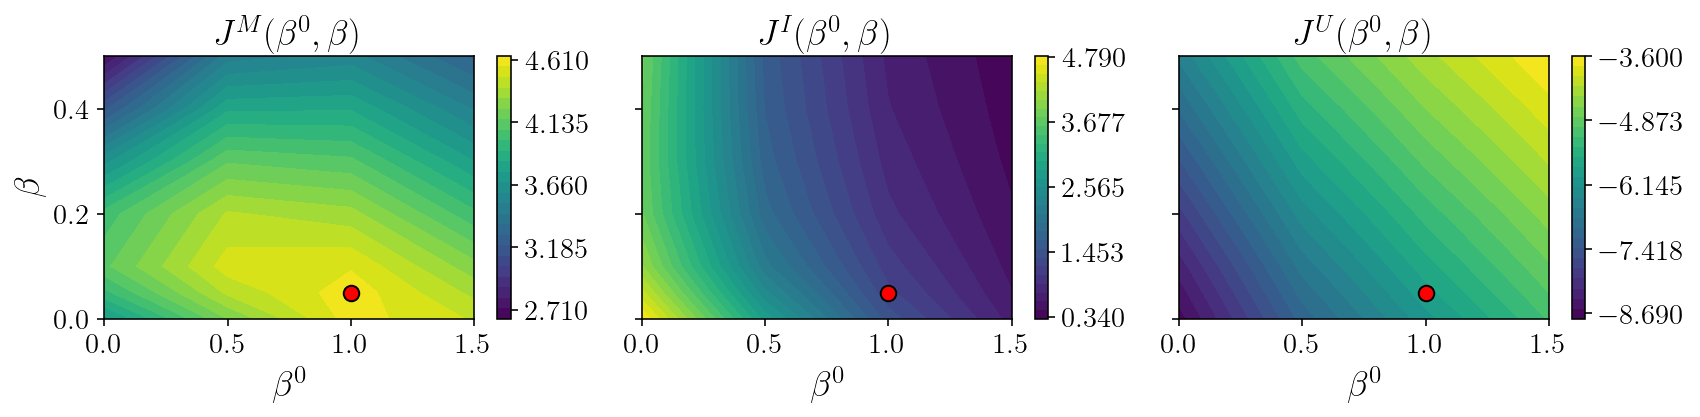

In [35]:
# --- 1. Définir les données ---
data = [
    #beta^0, beta,MM,IT,UT
    (0, 0, 3.73, 4.79, -8.69),
    (0.5, 0, 4.24,2.79,-7.12),
    (1, 0, 4.60,1.43,-6.08),
    (1.5, 0, 4.47,0.69,-5.18),

    (0, 0.1, 4.14,4.07,-8.31),
    (0, 0.2, 4.03,3.77,-7.87),
    (0, 0.3,3.65,3.72,-7.42),
    (0, 0.4,3.18,3.75,-6.98),
    (0, 0.5,2.71,3.80,-6.55),


    (0.5, 0.1, 4.52,2.15,-6.72),
    (0.5, 0.2, 4.41,1.86,-6.30),
    (0.5, 0.3, 4.15,1.72,-5.89),
    (0.5, 0.4, 3.82,1.64,-5.49),
    (0.5, 0.5,3.48,1.60,-5.1),

    (1, 0.05,4.61,1.24,-5.88),
    (1, 0.1,4.55,1.12,-5.69),
    (1, 0.2, 4.35,0.94,-5.32),
    (1, 0.3, 4.10,0.84,-4.95),
    (1, 0.4, 3.83,0.76,-4.60),
    (1, 0.5,3.55,0.71,-4.27),


    (1.5, 0.1,4.27,0.55,-4.83),
    (1.5, 0.2, 4.02,0.47,-4.5),
    (1.5, 0.3, 3.76,0.41,-4.18),
    (1.5, 0.4, 3.51,0.37,-3.88),
    (1.5, 0.5,3.26,0.34,-3.60),
]

df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader","PnL_UninformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')
rbf_ut = Rbf(df["beta0"], df["beta"], df["PnL_UninformedTrader"], function='multiquadric')


PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)
PnL_UT_full = rbf_ut(B0_grid, B_grid)


# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten(),
    "PnL_UninformedTrader": PnL_UT_full.flatten()

})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
idx_max_ut = df["PnL_UninformedTrader"].idxmax()

max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_mm, ["beta0", "beta", "PnL_InformedTrader"]]
max_ut = df.loc[idx_max_mm, ["beta0", "beta", "PnL_UninformedTrader"]]


# --- 6. Plot ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=30, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, edgecolors="black", zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title(r"$J^M(\beta^0,\beta)$",fontsize=fsL)
axes[0].set_xlabel(r"$\beta^0$",fontsize=fsL)
axes[0].set_ylabel(r"$\beta$",fontsize=fsL)
cbar=fig.colorbar(c1, ax=axes[0])
cbar.set_ticks(np.linspace(PnL_MM_full.min(), PnL_MM_full.max(), 5))


# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=30, cmap="viridis")
axes[1].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, edgecolors="black", zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title(r"$J^I(\beta^0,\beta)$",fontsize=fsL)
axes[1].set_xlabel(r"$\beta^0$",fontsize=fsL)
cbar= fig.colorbar(c2, ax=axes[1])
cbar.set_ticks(np.linspace(PnL_IT_full.min(), PnL_IT_full.max(), 5))


c3 = axes[2].contourf(B0_grid, B_grid, PnL_UT_full, levels=30, cmap="viridis")
axes[2].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, edgecolors="black", zorder=5)
axes[2].set_xlim(B0_grid.min(), B0_grid.max())
axes[2].set_ylim(B_grid.min(), B_grid.max())
axes[2].set_title(r"$J^U(\beta^0,\beta)$",fontsize=fsL)
axes[2].set_xlabel(r"$\beta^0$",fontsize=fsL)
cbar = fig.colorbar(c3, ax=axes[2])
cbar.set_ticks(np.linspace(PnL_UT_full.min(), PnL_UT_full.max(), 5))


fig.tight_layout()
plt.savefig("figures_Stackelberg/new_table_k_075.pdf")

### k=0.75, as a function of $\beta^1$ (need to add more points)

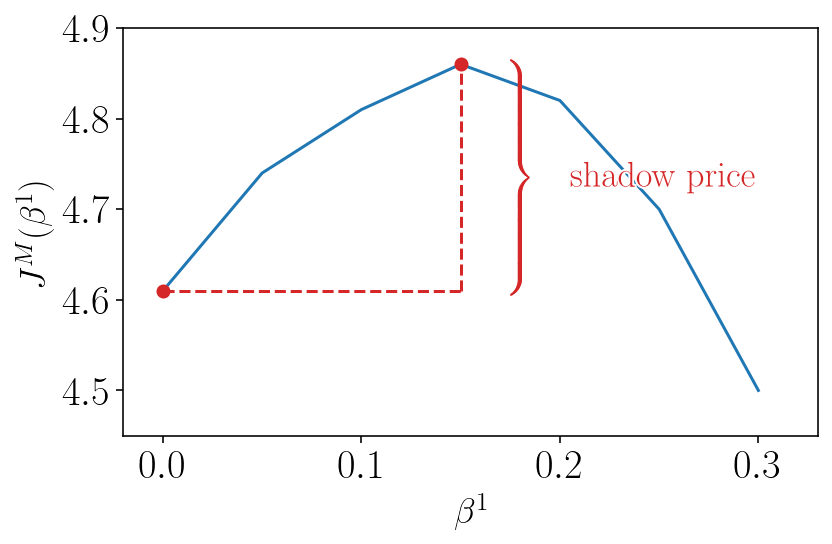

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe

# --- Configuration LaTeX ---
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})

# --- Données ---
beta1 = np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
Y     = np.array([4.61, 4.74, 4.81, 4.86, 4.82, 4.70, 4.50])

x1, y1 = 0.0, 4.61
x2, y2 = 0.15, 4.86
xi, yi = x2, y1  # intersection

# Couleur uniforme
red = 'tab:red'

fig, ax = plt.subplots(figsize=(6, 4))

# --- Courbe et points ---
ax.plot(beta1, Y, color="tab:blue")
ax.scatter([x1, x2], [y1, y2], color=red, zorder=5)

# --- Segments rouges pointillés ---
ax.plot([x1, xi], [y1, y1], '--', color=red, lw=1.5)
ax.plot([xi, xi], [yi, y2], '--', color=red, lw=1.5)

# --- Accolade verticale (ouverte vers la gauche, pointe vers le texte) ---
x_brace = xi + 0.025   # position horizontale à droite du segment
y_mid   = (yi + y2) / 2
brace_text = r"$\left. \rule{0cm}{2.2cm} \right\}$"  # accolade inversée (pointe vers le texte)

ax.text(x_brace, y_mid, brace_text,
        color=red, fontsize=fsL,
        va='center', ha='left')

# --- Texte "shadow price" horizontal ---
ax.text(x_brace + 0.03, y_mid, r"\text{shadow price}",
        color=red, fontsize=fsL,
        va='center', ha='left',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# --- Mise en forme ---
ax.set_xlabel(r'$\beta^1$', fontsize=fsL)
ax.set_ylabel(r'$J^M(\beta^1)$', fontsize=fsL)
ax.set_xlim(-0.02, 0.33)
ax.set_ylim(4.45, 4.9)
plt.tight_layout()
plt.savefig('figures_Stackelberg/opt_beta1.pdf')
plt.show()


### k = 1

### Former tables

In [286]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Définir les données ---
data = [
    (0, 0, 3.54, 4.99),
    (0.3, 0, 5.08, 3.50),
    (0.5, 0, 5.85, 2.74),
    (0.8, 0, 6.68, 1.86),
    (1.0, 0, 7.04, 1.42),

    (0, 0.1, 4.74, 3.91),
    (0, 0.3, 4.96, 3.62),
    (0, 0.5, 4.55, 3.82),

    (0.1, 0.1, 5.17, 3.45),
    (0.3, 0.3, 5.92, 2.36),
    (0.5, 0.5, 5.88, 1.76),
    (1.0, 1.0, 5.01, 0.74),

    (0.8, 0.05, 6.71, 1.82),
    (0.8, 0.1, 6.92, 1.44),
    (0.8, 0.3, 6.74, 1.14),
    (0.8, 0.5, 6.26, 1.08),

    (1.0, 0.05, 7.12, 1.23),
    (1.0, 0.1, 7.13, 1.11),
    (1.0, 0.3, 6.86, 0.86),
    (1.0, 0.5, 6.37, 0.78)
]

df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')

PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)

# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten()
})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_it, ["beta0", "beta", "PnL_InformedTrader"]]

# --- 6. Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=50, cmap="viridis")
axes[1].scatter(max_it["beta0"], max_it["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

fig.tight_layout()
plt.savefig("figures_Stackelberg/table_k_05.pdf")

In [32]:
from scipy.interpolate import Rbf

# --- 1. Définir les données ---
data = [
    (0, 0, 3.54, 4.99),
    (0.05, 0, 3.40, 4.72),
    (0.5, 0, 3.01, 2.76),
    (1.0, 0, 2.94, 1.43),
    (2.0, 0, 2.20, 0.32),

    (0, 0.1, 3.93, 3.89),
    (0, 0.3, 2.91, 3.43),

    (0.1, 0.1, 3.17, 2.10),
    (0.05, 0.1, 3.79, 3.66),
]
df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader"])

# --- 2. Définir la grille carrée jusqu'à borne_max ---
borne_max = min(df["beta0"].max(), df["beta"].max())
beta0_lin = np.linspace(df["beta0"].min(), borne_max, 100)
beta_lin  = np.linspace(df["beta"].min(),  borne_max, 100)
B0, B = np.meshgrid(beta0_lin, beta_lin)

# --- 3. Interpolation RBF pour remplir les trous ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')

PnL_MM_interp = rbf_mm(B0, B)
PnL_IT_interp = rbf_it(B0, B)

# --- 4. Trouver les maxima dans les données brutes ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_it, ["beta0", "beta", "PnL_InformedTrader"]]

# --- 5. Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

c1 = axes[0].contourf(B0, B, PnL_MM_interp, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(0, borne_max)
axes[0].set_ylim(0, borne_max)
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

c2 = axes[1].contourf(B0, B, PnL_IT_interp, levels=50, cmap="viridis")
axes[1].scatter(max_it["beta0"], max_it["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(0, borne_max)
axes[1].set_ylim(0, borne_max)
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

fig.tight_layout()
plt.savefig("figures_Stackelberg/table_k_1.pdf")

In [42]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Définir les nouvelles données ---
data = [
    (0,0,3.54,4.99),
    (0.5, 0, 3.74, 2.75),
    (1.0, 0, 3.87, 1.42),
    (1.5, 0, 3.63, 0.70),
    (2.0, 0, 3.16, 0.32),

    (0.25, 0.05, 3.95, 3.20),
    (0.5, 0.05, 3.93, 2.36),
    (0.75, 0.05, 3.92, 1.72),

    (0.25, 0.1, 4.02, 2.87),
    (0.3, 0.1, 4.01, 2.70),
    (0.5, 0.1, 3.96, 2.10),
    (1.0, 0.1, 3.80, 1.10),

    (0.25, 0.12, 4.02, 2.77),
    (0.5, 0.12, 3.95, 2.03),
    (0.75, 0.12, 3.88, 1.47),

    (0, 0.05, 4.04, 4.27),
    (0, 0.1, 4.17, 3.90),
    (0, 0.15, 4.10, 3.69),
    (0, 0.2, 3.97, 3.58),
    (0, 0.3, 3.46, 3.49),

    (0.5, 0.08, 3.96, 2.20),
    (0.7, 0.08, 3.93, 1.71),
    (0.9, 0.15, 3.76, 1.15)
]
df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')

PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)

# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten()
})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_it, ["beta0", "beta", "PnL_InformedTrader"]]

# --- 6. Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=50, cmap="viridis")
axes[1].scatter(max_it["beta0"], max_it["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

fig.tight_layout()
plt.savefig("figures_Stackelberg/table_k_0.85.pdf")


In [38]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Définir les nouvelles données ---
data = [
    (0.0, 0.0, 5.49, 3.08),
    (0.3, 0, 5.87, 2.02),
    (0.5, 0, 6.39, 1.52),
    (0.8, 0, 7.02, 1.94),
    (1.0, 0, 7.24, 0.67),

    (0, 0.1, 5.26, 2.59),
    (0, 0.3, 5.07, 2.69),
    (0, 0.5, 4.56, 3.01),

    (0.1, 0.1, 5.56, 2.21),
    (0.3, 0.3, 5.99, 1.60),
    (0.5, 0.5, 5.82, 1.22),

    (0.8, 0.05, 7.05, 0.83),
    (0.8, 0.1, 7.03, 0.75),
    (0.8, 0.3, 6.68, 0.64),

    (1.0, 0.05, 7.21, 0.60),
    (1.0, 0.1, 7.15, 0.54),
    (1.0, 0.3, 6.75, 0.45)
]
df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')

PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)

# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten()
})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_it, ["beta0", "beta", "PnL_InformedTrader"]]

# --- 6. Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=50, cmap="viridis")
axes[1].scatter(max_it["beta0"], max_it["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

fig.tight_layout()
plt.savefig("figures_Stackelberg/table_beta_1_01_k_05.pdf")



In [74]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Définir les données ---
data = [
    (0, 0, 3.54, 4.99),
    (0.5, 0, 4.57, 2.75),
    (1.0, 0, 5.03, 1.42),
    
    (0, 0.05, 4.17, 4.28),
    (0, 0.1, 4.41, 3.90),
    (0, 0.2, 4.36, 3.61),
    (0, 0.3, 4.07, 3.54),
    
    (0.5, 0.05, 4.81, 2.36),
    (0.5, 0.08, 4.88, 2.19),
    (0.5, 0.1, 4.89, 2.11),
    
    (0.7, 0.03, 4.92, 1.93),
    (0.7, 0.05, 4.96, 1.83),
    (0.7, 0.07, 4.98, 1.75),
    (0.7, 0.09, 4.98, 1.67),
    (0.7, 0.1, 4.98, 1.64),
    (0.7, 0.12, 4.97, 1.57),
    
    (0.8, 0.05, 5.01, 1.61),
    (0.8, 0.08, 5.01, 1.50),
    (0.8, 0.09, 5.01, 1.47),
    (0.8, 0.1, 5.00, 1.44),
    (0.8, 0.12, 4.98, 1.38),
    
    (0.9, 0.03, 5.02, 1.49),
    (0.9, 0.05, 5.03, 1.41),
    (0.9, 0.07, 5.03, 1.35),
    (0.9, 0.08, 5.02, 1.32),
    (0.9, 0.09, 5.02, 1.29),
    
    (0.95, 0, 5.01, 1.52),
    (0.95, 0.03, 5.04, 1.39),
    (0.95, 0.05, 5.04, 1.32),
    
    (1.0, 0.05, 5.04, 1.24),
    (1.0, 0.1, 5.00, 1.10),
    
    (1.5, 0.05, 4.86, 0.61)
]

df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader"])

# --- 2. Filtrer pour beta <= 0.1 ---
df = df[df["beta"] <= 0.1]

# --- 3. Construire la grille pour interpolation ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 4. Interpolation RBF ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')

PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)

# --- 5. Trouver les maxima ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_it, ["beta0", "beta", "PnL_InformedTrader"]]

# --- 6. Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=50, cmap="viridis")
axes[1].scatter(max_it["beta0"], max_it["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

fig.tight_layout()
plt.savefig("figures_Stackelberg/table_k_07.pdf")



In [304]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Définir les nouvelles données ---
data = [
    (0,0,4.18,3.95),
    (0.3, 0.0, 5.54, 2.69),
    (0.5, 0.0, 6.21, 2.06),
    (0.8, 0.0, 6.90, 1.34),
    (1.0, 0.0, 7.18, 1.00),

    (0.0, 0.1, 5.05, 3.19),
    (0.0, 0.3, 5.05, 3.11),
    (0.0, 0.5, 4.59, 3.37),

    (0.1, 0.1, 5.45, 2.77),
    (0.3, 0.3, 5.98, 1.95),
    (0.5, 0.5, 5.87, 1.47),

    (0.8, 0.05, 6.99, 1.17),
    (0.8, 0.1, 7.00, 1.06),
    (0.8, 0.3, 6.73, 0.86),

    (1.0, 0.05, 7.20, 0.87),
    (1.0, 0.1, 7.17, 0.79),
    (1.0, 0.3, 6.82, 0.63)
]
df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric')

PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)

# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten()
})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_it, ["beta0", "beta", "PnL_InformedTrader"]]

# --- 6. Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=50, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=80, zorder=5)
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title("PnL Market Maker")
axes[0].set_xlabel(r"$\beta^0$")
axes[0].set_ylabel(r"$\beta$")
fig.colorbar(c1, ax=axes[0])

# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=50, cmap="viridis")
axes[1].scatter(max_it["beta0"], max_it["beta"], color="red", s=80, zorder=5)
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title("PnL Informed Trader")
axes[1].set_xlabel(r"$\beta^0$")
fig.colorbar(c2, ax=axes[1])

fig.tight_layout()
plt.savefig("figures_Stackelberg/table_beta_1_005_k_05.pdf")



# Test concavity :

In [4]:
from scipy.integrate import simps
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# --- Paramètres ---
sigma_Z_bar = 50
eta_alpha = 0.3
sigma_alpha = 5
k_values = np.linspace(0.5, 1, 5)
beta0_values = np.linspace(0, 3, 10)
beta1_values = np.linspace(0,1,10)
T = 0.99
kappa = 0.07
eta_Z = 10

# --- Fonctions utilitaires ---
def F(t):
    return (1 - np.exp(-eta_alpha * (T - t))) / eta_alpha

def E_alpha2(t):
    return (sigma_alpha ** 2) / (2 * eta_alpha) * (1 - np.exp(-2 * eta_alpha * t))

def V(t, beta0, k,sigma = sigma_Z_bar):
    return sigma**2 * np.exp(-2 * k * beta0) * (1 - np.exp(-2 * eta_Z * t)) / (2 * eta_Z)

nt = 700
t_grid = np.linspace(0, T, nt)

def JM(beta0, k,sigma=sigma_Z_bar, eps=1e-12):
    integrand = np.zeros_like(t_grid)
    integrand_UT = np.zeros_like(t_grid)

    for i, t in enumerate(t_grid):
        ns = max(2, int(nt * t / T))
        s_grid = np.linspace(0, t, ns)
        E_a2_s = E_alpha2(s_grid)
        F_s = F(s_grid)
        denom_s = F_s * np.sqrt(E_a2_s)

        if beta0 == 0:
            phi_s = np.full_like(denom_s, 0.5)
            varphi_s = np.full_like(denom_s, 1/np.sqrt(2*np.pi))
        else:
            denom_s_safe = np.where(denom_s < eps, np.inf, denom_s)
            phi_s = norm.cdf(-beta0 / denom_s_safe)
            phi_s[denom_s < eps] = 0.0

        inner_integral = simps(
            1 / kappa * np.exp(-eta_alpha * (t - s_grid)) * (-E_a2_s * phi_s * F_s),
            s_grid
        )

        E_a2_t = E_alpha2(t)
        Ft = F(t)
        denom_t = Ft * np.sqrt(E_a2_t)

        if beta0 == 0:
            phi_t = 0.5
            varphi_t = varphi_tt = 1 / np.sqrt(2*np.pi)
        elif denom_t < eps:
            phi_t = varphi_t = varphi_tt = 0.0
        else:
            phi_t = norm.cdf(-beta0 / denom_t)
            varphi_t = norm.pdf(-beta0 / denom_t)
            varphi_tt = norm.pdf(beta0 / denom_t)

        term = (
            inner_integral
            + 1/(2*kappa) * (
                Ft**2 * E_a2_t * phi_t
                + beta0 * Ft * np.sqrt(E_a2_t) * varphi_t
                - beta0**2 * phi_t)
            + kappa * V(t, beta0, k,sigma)
            + 2 * beta0 * np.sqrt(V(t, beta0, k,sigma) / (2 * np.pi))
        )
        term_UT = -(kappa * V(t, beta0, k,sigma)
            + 2 * beta0 * np.sqrt(V(t, beta0, k,sigma) / (2 * np.pi)))

        integrand[i] = term
        integrand_UT[i] = term_UT

    return (simps(integrand, t_grid),simps(integrand_UT,t_grid))

### Plot $\beta^0$ and $k$

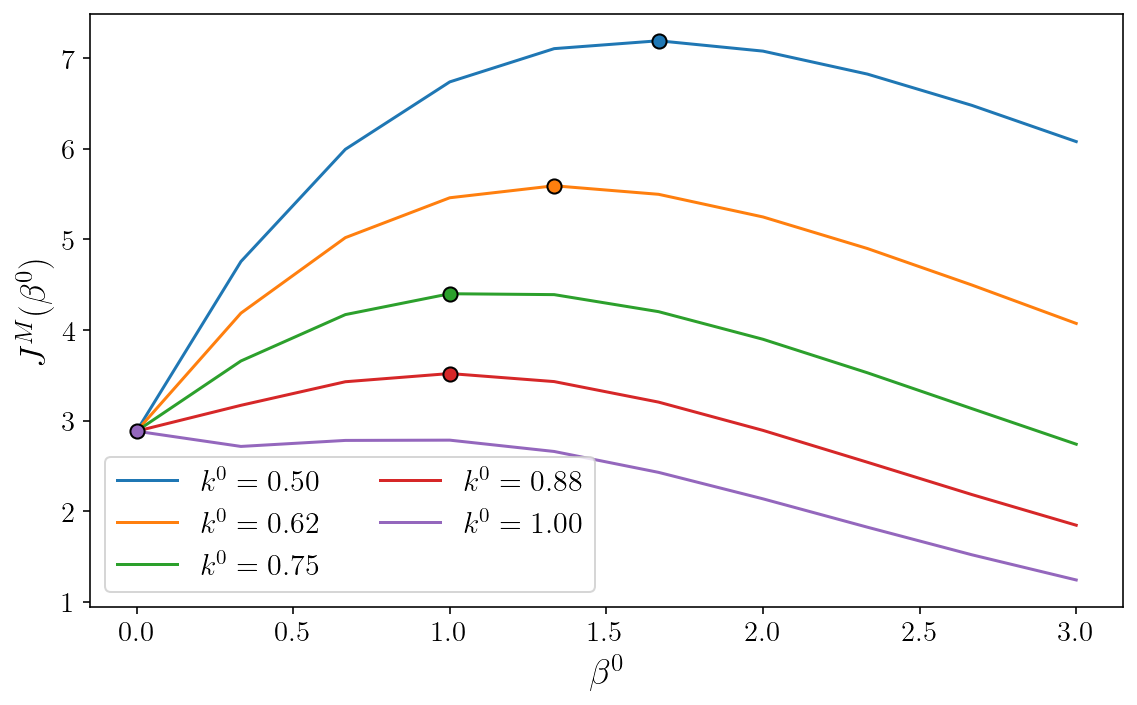

In [30]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 
          'tab:olive', 'tab:cyan']

l = []
plt.figure(figsize=(8, 5))

for i, k in enumerate(k_values):
    color = colors[i % len(colors)]  # cycle sur les couleurs
    JM_vals = [JM(beta0, k)[0] for beta0 in beta0_values]
    
    line, = plt.plot(beta0_values, JM_vals, label=fr'$k^0={k:.2f}$', color=color)
    
    # Trouver le maximum et ajouter un point
    max_idx = np.argmax(JM_vals)
    max_beta0 = beta0_values[max_idx]
    max_JM = JM_vals[max_idx]
    l.append((k, max_beta0, max_JM))
    
    plt.scatter(max_beta0, max_JM, color=color, s=50, zorder=5, edgecolors="black")
    
plt.xlabel(r'$\beta^0$', fontsize=fsL)
plt.ylabel(r'$J^M(\beta^0)$', fontsize=fsL)
plt.legend(fontsize=fs, ncol=2, frameon=True, framealpha=0.8, markerscale=0.8)
plt.tight_layout()
plt.savefig("figures_Stackelberg/test_concavity_with_max.pdf", format="pdf", dpi=dpi)
plt.show()


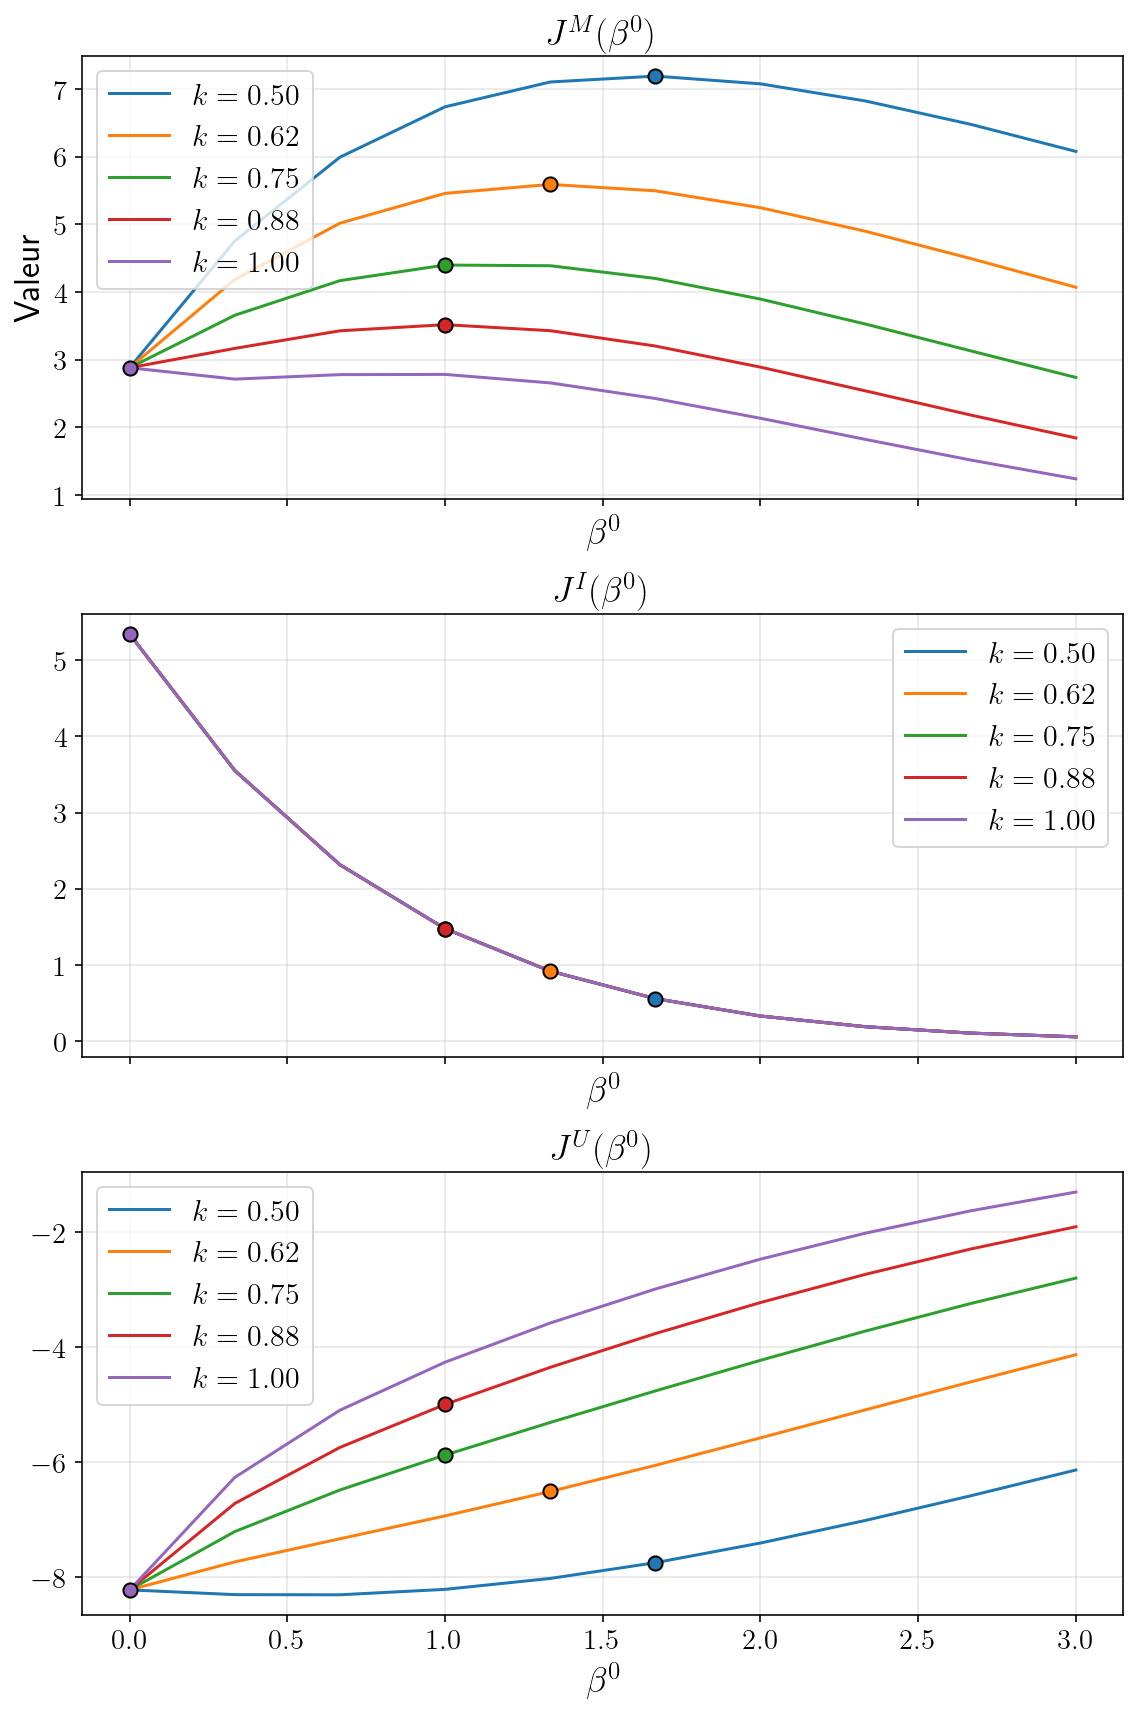

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
titles = [r'$J^M(\beta^0)$', r'$J^I(\beta^0)$', r'$J^U(\beta^0)$']

max_points = []  # liste de tuples (k, beta0_max, JM_max)
for k in k_values:
    JM_vals = [JM(beta0, k)[0] for beta0 in beta0_values]
    max_idx = np.argmax(JM_vals)
    max_beta0 = beta0_values[max_idx]
    max_JM = JM_vals[max_idx]
    max_points.append((k, max_beta0, max_JM))

# Étape 2 : tracé des 3 sous-graphiques côte à côte
for i, ax in enumerate(axes):
    for k in k_values:
        JM_vals = [JM(beta0, k)[0] for beta0 in beta0_values]
        JU_vals = [JM(beta0, k)[1] for beta0 in beta0_values]
        JI_vals = [-JU - JM for JU, JM in zip(JU_vals, JM_vals)]
        
        if i == 0:
            y_vals = JM_vals
        elif i == 1:
            y_vals = JI_vals
        else:
            y_vals = JU_vals
        
        line, = ax.plot(beta0_values, y_vals, label=fr'$k={k:.2f}$')
    
    # Ajouter les points communs (max de J^M)
    for k, beta0_star, _ in max_points:
        color = None
        # retrouver la couleur de la ligne correspondante à k
        for line in ax.get_lines():
            if line.get_label() == fr'$k={k:.2f}$':
                color = line.get_color()
                break
        if color:
            y_val = None
            if i == 0:
                y_val = [JM(beta0_star, k)[0] for _ in [0]][0]
            elif i == 1:
                y_val = -JM(beta0_star, k)[0] - JM(beta0_star, k)[1]
            else:
                y_val = [JM(beta0_star, k)[1] for _ in [0]][0]
            
            ax.scatter(beta0_star, y_val, color=color, s=50, zorder=5, edgecolors="black")
    
    ax.set_title(titles[i], fontsize=fsL)
    ax.set_xlabel(r'$\beta^0$', fontsize=fsL)
    ax.legend(fontsize=fs, ncol=1, frameon=True, framealpha=0.8, markerscale=0.8)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Valeur", fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/test_concavity_with_max_subplots.pdf", format="pdf", dpi=dpi)
plt.show()

### Plot $\beta^0$ and $\sigma^Z$ 

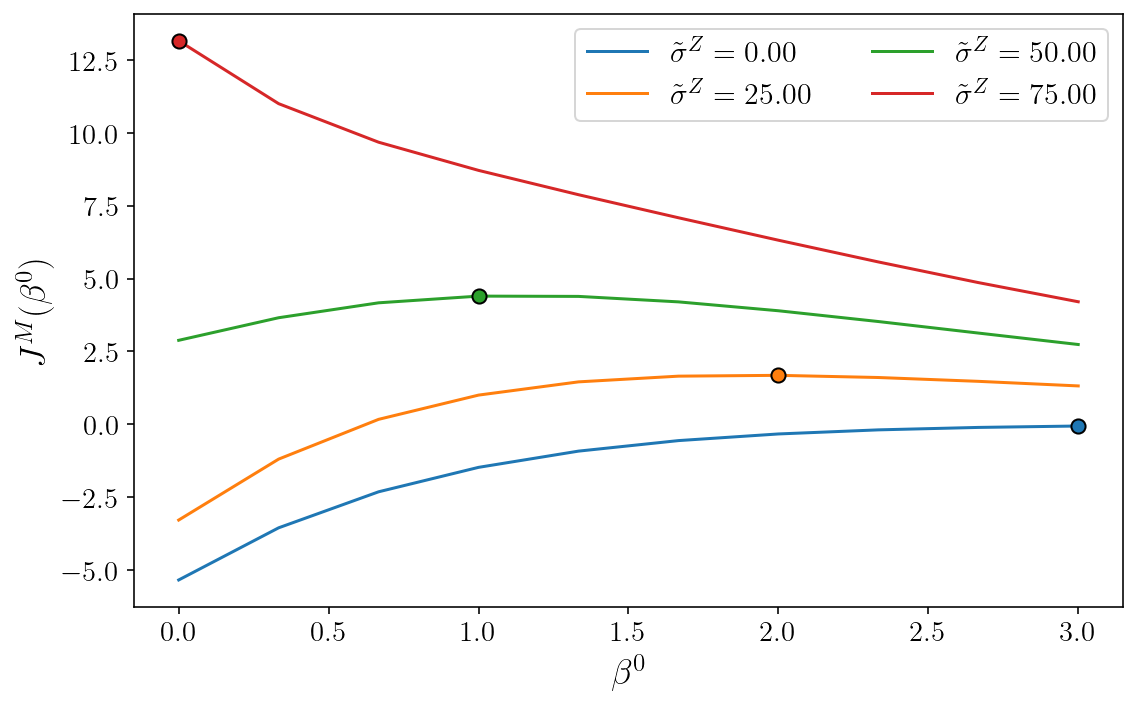

In [29]:
l = []
k = 0.75
sigma_values = np.array([0, 25, 50, 75])

# Palette tab:XXX de Matplotlib
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
          'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray',
          'tab:olive', 'tab:cyan']

plt.figure(figsize=(8, 5))

for i, sigma in enumerate(sigma_values):
    color = colors[i % len(colors)]  # cycle sur les couleurs tab:
    JM_vals = [JM(beta0, k, sigma)[0] for beta0 in beta0_values]
    
    line, = plt.plot(beta0_values, JM_vals,
                     label=fr'$\tilde{{\sigma}}^Z={sigma:.2f}$',
                     color=color)
    
    # Trouver le maximum et ajouter un point
    max_idx = np.argmax(JM_vals)
    max_beta0 = beta0_values[max_idx]
    max_JM = JM_vals[max_idx]
    l.append((sigma, max_beta0, max_JM))
    
    plt.scatter(max_beta0, max_JM, color=color, s=50,
                zorder=5, edgecolors="black")

plt.xlabel(r'$\beta^0$', fontsize=fsL)
plt.ylabel(r'$J^M(\beta^0)$', fontsize=fsL)
plt.legend(fontsize=fs, ncol=2, frameon=True, framealpha=0.8, markerscale=0.8)
plt.tight_layout()
plt.savefig("figures_Stackelberg/test_spread.pdf", format="pdf", dpi=dpi)
plt.show()


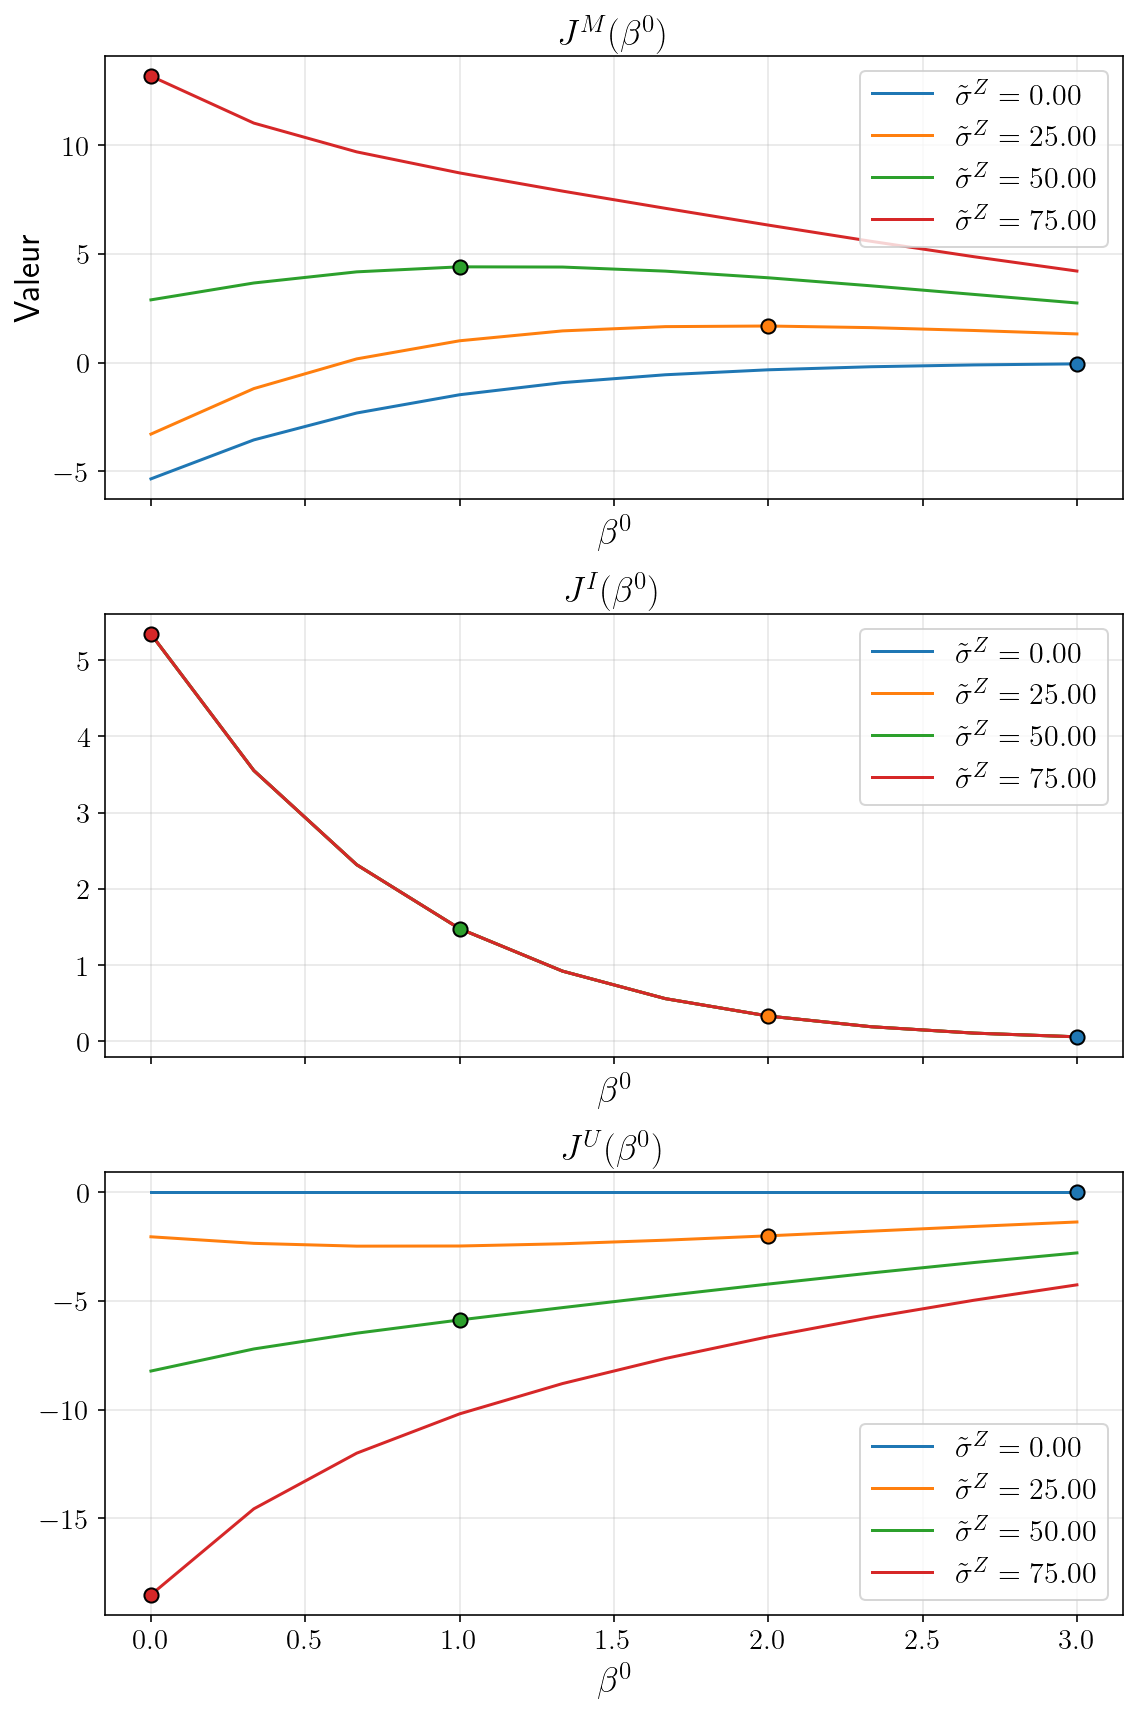

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
titles = [r'$J^M(\beta^0)$', r'$J^I(\beta^0)$', r'$J^U(\beta^0)$']
k = 0.75
sigma_values = np.array([0,25,50,75])
max_points = []  # liste de tuples (k, beta0_max, JM_max)
for sigma in sigma_values:
    JM_vals = [JM(beta0, k,sigma)[0] for beta0 in beta0_values]
    max_idx = np.argmax(JM_vals)
    max_beta0 = beta0_values[max_idx]
    max_JM = JM_vals[max_idx]
    max_points.append((sigma, max_beta0, max_JM))

# Étape 2 : tracé des 3 sous-graphiques côte à côte
for i, ax in enumerate(axes):
    for sigma in sigma_values:
        JM_vals = [JM(beta0, k,sigma)[0] for beta0 in beta0_values]
        JU_vals = [JM(beta0, k,sigma)[1] for beta0 in beta0_values]
        JI_vals = [-JU - JM for JU, JM in zip(JU_vals, JM_vals)]
        
        if i == 0:
            y_vals = JM_vals
        elif i == 1:
            y_vals = JI_vals
        else:
            y_vals = JU_vals
        
        line, = ax.plot(beta0_values, y_vals, label= fr'$\tilde{{\sigma}}^Z={sigma:.2f}$')
    
    # Ajouter les points communs (max de J^M)
    for sigma, beta0_star, _ in max_points:
        color = None
        # retrouver la couleur de la ligne correspondante à k
        for line in ax.get_lines():
            if line.get_label() ==  fr'$\tilde{{\sigma}}^Z={sigma:.2f}$':
                color = line.get_color()
                break
        if color:
            y_val = None
            if i == 0:
                y_val = [JM(beta0_star, k,sigma)[0] for _ in [0]][0]
            elif i == 1:
                y_val = -JM(beta0_star, k,sigma)[0] - JM(beta0_star, k,sigma)[1]
            else:
                y_val = [JM(beta0_star, k,sigma)[1] for _ in [0]][0]
            
            ax.scatter(beta0_star, y_val, color=color, s=50, zorder=5, edgecolors="black")
    
    ax.set_title(titles[i], fontsize=fsL)
    ax.set_xlabel(r'$\beta^0$', fontsize=fsL)
    ax.legend(fontsize=fs, ncol=1, frameon=True, framealpha=0.8, markerscale=0.8)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Valeur", fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/test_concavity_with_max_subplots_sig.pdf", format="pdf", dpi=dpi)
plt.show()

# As a function of $\beta^0$ and $\beta^1$

In [6]:
def V(t, beta0,beta1, k1,k0):
    return sigma_Z_bar**2 * np.exp(-2 * (k0 * beta0+ k1* beta1)) * (1 - np.exp(-2 * eta_Z * t)) / (2 * eta_Z)

def f(t,beta1):
    return F(t)-beta1


def JM_big(beta0,beta1, k1,k0, eps=1e-12):
    integrand = np.zeros_like(t_grid)

    for i, t in enumerate(t_grid):
        ns = max(2, int(nt * t / T))
        s_grid = np.linspace(0, t, ns)
        E_a2_s = E_alpha2(s_grid)
        F_s = f(s_grid,beta1)
        denom_s = np.abs(F_s) * np.sqrt(E_a2_s)

        if beta0 == 0:
            phi_s = np.full_like(denom_s, 0.5)
            varphi_s = np.full_like(denom_s, 1/np.sqrt(2*np.pi))
        else:
            denom_s_safe = np.where(denom_s < eps, np.inf, denom_s)
            phi_s = norm.cdf(-beta0 / denom_s_safe)
            phi_s[denom_s < eps] = 0.0

        inner_integral = simps((F_s>0)*1 / kappa * np.exp(-eta_alpha * (t - s_grid)) * (-E_a2_s * phi_s * F_s)
                               +(F_s<0)*1 / kappa * np.exp(-eta_alpha * (t - s_grid)) * (E_a2_s * phi_s * np.abs(F_s)),
            s_grid
        )

        E_a2_t = E_alpha2(t)
        Ft = f(t,beta1)
        denom_t = np.abs(Ft) * np.sqrt(E_a2_t)

        if beta0 == 0:
            phi_t = 0.5
            varphi_t = varphi_tt = 1 / np.sqrt(2*np.pi)
        elif denom_t < eps:
            phi_t = varphi_t = varphi_tt = 0.0
        else:
            phi_t = norm.cdf(-beta0 / denom_t)
            varphi_t = norm.pdf(-beta0 / denom_t)
            varphi_tt = norm.pdf(beta0 / denom_t)
        term = (
            inner_integral
            + 1/(2*kappa) * (
                Ft**2 * E_a2_t * phi_t
                + beta0 * np.abs(Ft) * np.sqrt(E_a2_t) * varphi_t
                - beta0**2 * phi_t)
            + kappa * V(t, beta0,beta1, k1,k0)
            + 2 * beta0 * np.sqrt(V(t, beta0,beta1, k1,k0) / (2 * np.pi))
            +beta1/kappa*((Ft>0)*E_a2_t*np.abs(Ft)*phi_t - (Ft<0)*E_a2_t*np.abs(Ft)*phi_t)
        )

        integrand[i] = term

    return simps(integrand, t_grid)

In [7]:
def JI(beta0,beta1, k1,k0, eps=1e-12):
    integrand = np.zeros_like(t_grid)

    for i, t in enumerate(t_grid):
        ns = max(2, int(nt * t / T))
        s_grid = np.linspace(0, t, ns)
        E_a2_s = E_alpha2(s_grid)
        F_s = f(s_grid,beta1)
        denom_s = np.abs(F_s) * np.sqrt(E_a2_s)

        if beta0 == 0:
            phi_s = np.full_like(denom_s, 0.5)
            varphi_s = np.full_like(denom_s, 1/np.sqrt(2*np.pi))
        else:
            denom_s_safe = np.where(denom_s < eps, np.inf, denom_s)
            phi_s = norm.cdf(-beta0 / denom_s_safe)
            phi_s[denom_s < eps] = 0.0

        inner_integral = simps((F_s>0)*1 / kappa * np.exp(-eta_alpha * (t - s_grid)) * (E_a2_s * phi_s * F_s)
                               +(F_s<0)*1 / kappa * np.exp(-eta_alpha * (t - s_grid)) * (-E_a2_s * phi_s * np.abs(F_s)),
            s_grid
        )

        E_a2_t = E_alpha2(t)
        Ft = f(t,beta1)
        denom_t = np.abs(Ft) * np.sqrt(E_a2_t)

        if beta0 == 0:
            phi_t = 0.5
            varphi_t = varphi_tt = 1 / np.sqrt(2*np.pi)
        elif denom_t < eps:
            phi_t = varphi_t = varphi_tt = 0.0
        else:
            phi_t = norm.cdf(-beta0 / denom_t)
            varphi_t = norm.pdf(-beta0 / denom_t)
            varphi_tt = norm.pdf(beta0 / denom_t)
        term = (
            inner_integral
            - 1/(2*kappa) * (
                Ft**2 * E_a2_t * phi_t
                + beta0 * np.abs(Ft) * np.sqrt(E_a2_t) * varphi_t
                - beta0**2 * phi_t)
            -beta1/kappa*((Ft>0)*E_a2_t*np.abs(Ft)*phi_t - (Ft<0)*E_a2_t*np.abs(Ft)*phi_t)
        )

        integrand[i] = term

    return simps(integrand, t_grid)

In [8]:
def JU(beta0,beta1, k1,k0, eps=1e-12):
    integrand = np.zeros_like(t_grid)


    for i, t in enumerate(t_grid):
        ns = max(2, int(nt * t / T))
        s_grid = np.linspace(0, t, ns)
        E_a2_s = E_alpha2(s_grid)
        F_s = f(s_grid,beta1)
        denom_s = np.abs(F_s) * np.sqrt(E_a2_s)

        if beta0 == 0:
            phi_s = np.full_like(denom_s, 0.5)
            varphi_s = np.full_like(denom_s, 1/np.sqrt(2*np.pi))
        else:
            denom_s_safe = np.where(denom_s < eps, np.inf, denom_s)
            phi_s = norm.cdf(-beta0 / denom_s_safe)
            phi_s[denom_s < eps] = 0.0


        E_a2_t = E_alpha2(t)
        Ft = f(t,beta1)
        denom_t = np.abs(Ft) * np.sqrt(E_a2_t)

        if beta0 == 0:
            phi_t = 0.5
            varphi_t = varphi_tt = 1 / np.sqrt(2*np.pi)
        elif denom_t < eps:
            phi_t = varphi_t = varphi_tt = 0.0
        else:
            phi_t = norm.cdf(-beta0 / denom_t)
            varphi_t = norm.pdf(-beta0 / denom_t)
            varphi_tt = norm.pdf(beta0 / denom_t)
            
        term = (
             - kappa * V(t, beta0,beta1, k1,k0)
            - 2 * beta0 * np.sqrt(V(t, beta0,beta1, k1,k0) / (2 * np.pi))
        )
        integrand[i] = term

    return simps(integrand, t_grid)

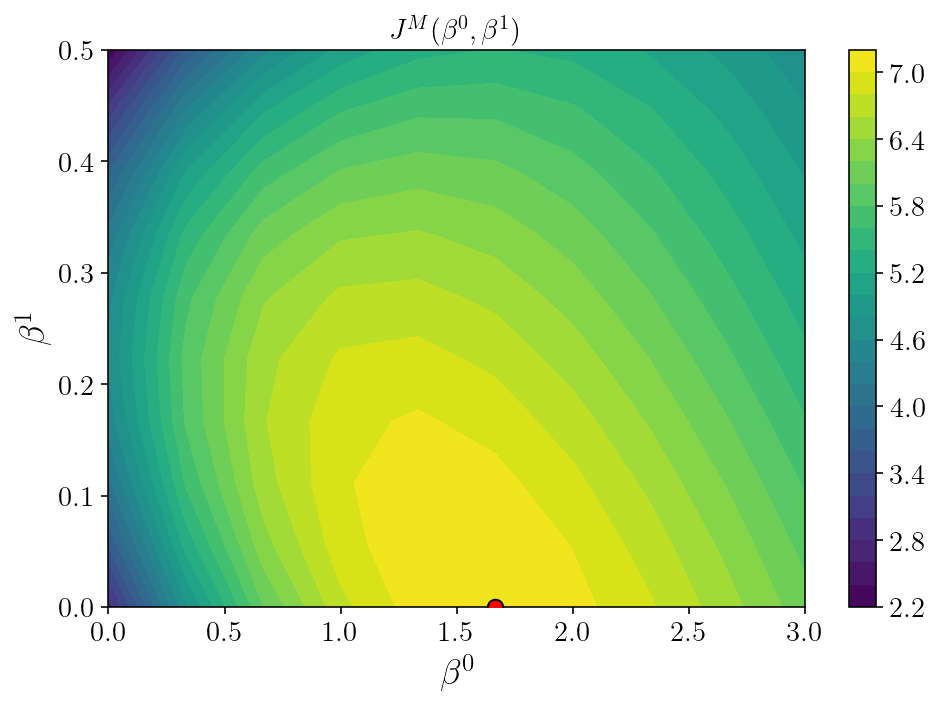

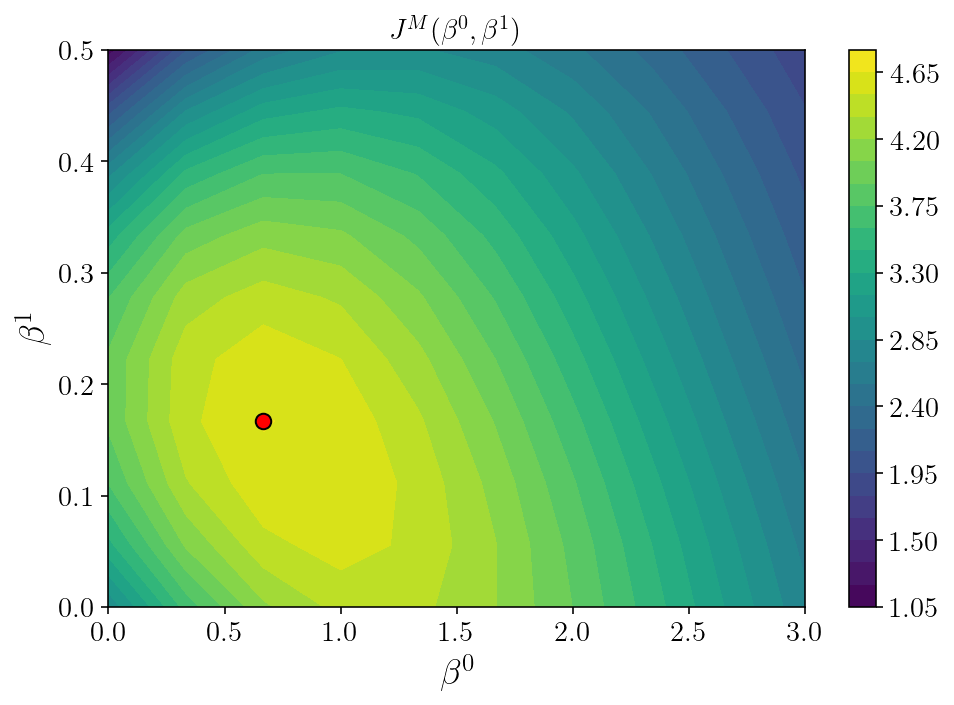

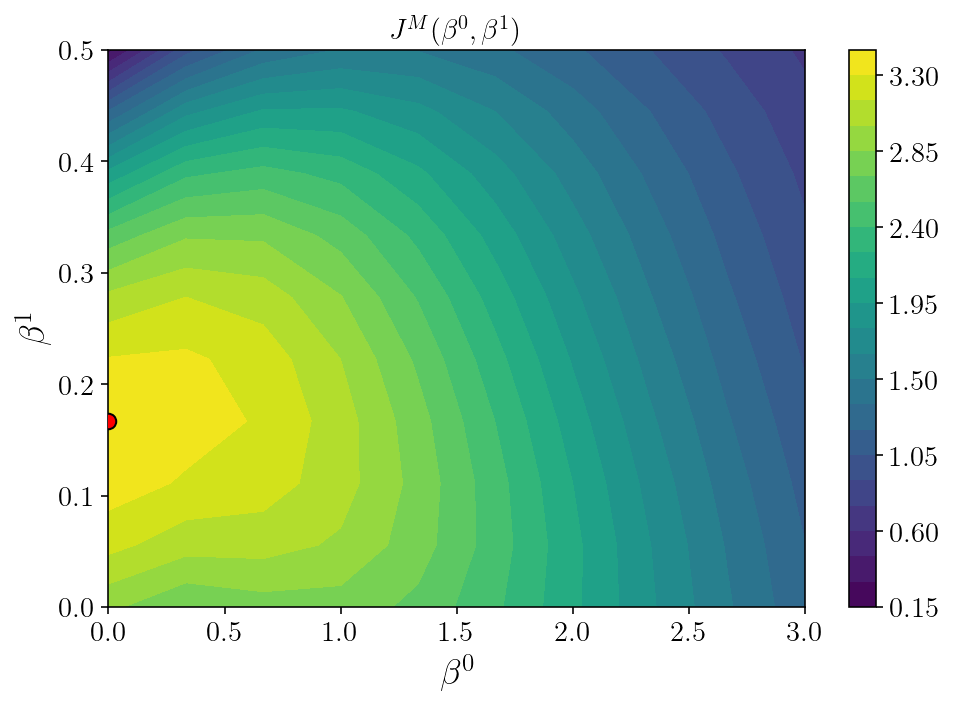

In [49]:
sigma_Z_bar = 50 
eta_alpha = 0.3
sigma_alpha = 5
k0 = 0.75
k_values =  np.linspace(0.5, 1., 3)
beta0_values = np.linspace(0, 3, 10)
beta1_values = np.linspace(0,.5,10)
T = 0.99
kappa = 0.07
eta_Z = 10
B0, B1 = np.meshgrid(beta0_values, beta1_values)
l = []
nt = 700
t_grid = np.linspace(0, T, nt)

# Boucle sur les k et création des heatmaps
for k in k_values:
    JM_vals = np.zeros_like(B0)

    # Calcul des valeurs de JMbig sur toute la grille
    for i in range(len(beta0_values)):
        for j in range(len(beta1_values)):
            JM_vals[j, i] = JM_big(beta0_values[i], beta1_values[j], k,k)


    plt.figure(figsize=(7, 5))
    contour = plt.contourf(B0, B1, JM_vals, levels=30, cmap="viridis")
    plt.colorbar(contour)

    # Trouver le maximum
    max_idx = np.unravel_index(np.argmax(JM_vals), JM_vals.shape)
    max_beta0 = beta0_values[max_idx[1]]
    max_beta1 = beta1_values[max_idx[0]]
    max_JM = JM_vals[max_idx]
    l.append((k,max_JM))

    plt.scatter(max_beta0, max_beta1, color="red", s=60, edgecolors="black", zorder=5)
    plt.xlabel(r"$\beta^0$",fontsize=fsL)
    plt.ylabel(r"$\beta^1$",fontsize = fsL)
    plt.title(r"$J^M(\beta^0,\beta^1)$")
    plt.tight_layout()
    plt.savefig(f"figures_Stackelberg/JM_heatmap_k_{k:.2f}.pdf",format="pdf",dpi=dpi)
    plt.show()

### Use of subplots

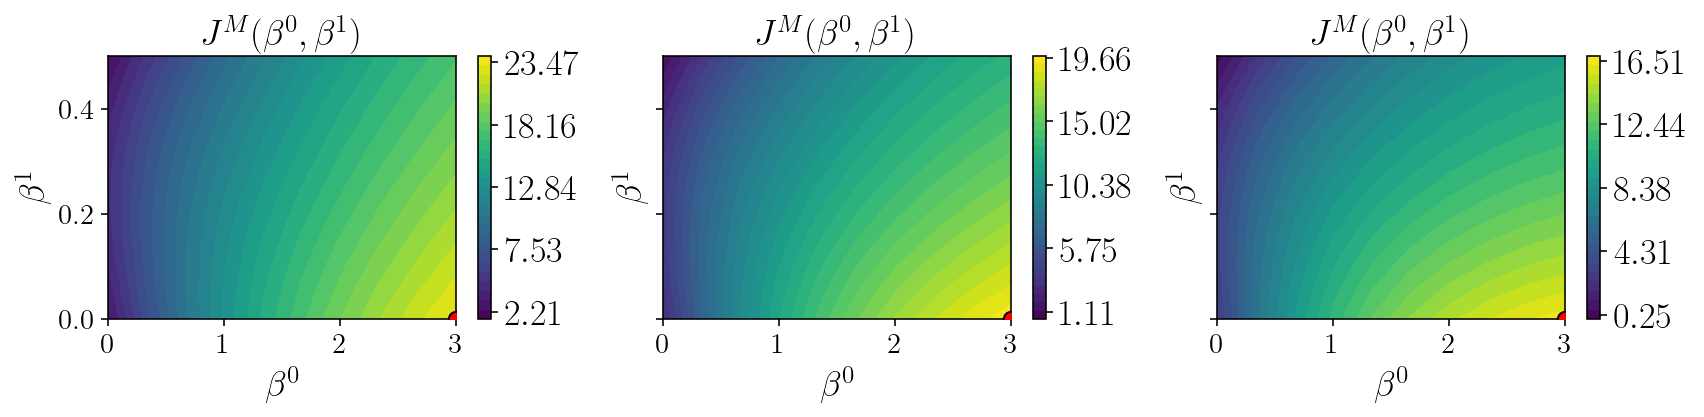

In [10]:
sigma_Z_bar = 50 
eta_alpha = 0.3
sigma_alpha = 5
k0 = 0.75
k_values = np.linspace(0.5, 1., 3)
beta0_values = np.linspace(0, 3, 10)
beta1_values = np.linspace(0, .5, 10)
T = 0.99
kappa = 0.07
eta_Z = 10
B0, B1 = np.meshgrid(beta0_values, beta1_values)
l = []
nt = 700
t_grid = np.linspace(0, T, nt)

# --- Figure avec subplots ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for idx, k in enumerate(k_values):
    ax = axes[idx]
    JM_vals = np.zeros_like(B0)

    # Calcul des valeurs de JMbig sur toute la grille
    for i in range(len(beta0_values)):
        for j in range(len(beta1_values)):
            JM_vals[j, i] = JM_big(beta0_values[i], beta1_values[j], k/5, k) #k_#1,k_0

    # --- Plot du heatmap ---
    c = ax.contourf(B0, B1, JM_vals, levels=30, cmap="viridis")

    # Trouver le maximum
    max_idx = np.unravel_index(np.argmax(JM_vals), JM_vals.shape)
    max_beta0 = beta0_values[max_idx[1]]
    max_beta1 = beta1_values[max_idx[0]]
    max_JM = JM_vals[max_idx]
    l.append((k, max_JM))

    # --- Ajouter le point du maximum ---
    ax.scatter(max_beta0, max_beta1, color="red", s=60, edgecolors="black", zorder=5)

    # --- Mise en forme uniforme ---
    ax.set_xlim(B0.min(), B0.max())
    ax.set_ylim(B1.min(), B1.max())
    ax.set_xlabel(r"$\beta^0$", fontsize=fsL)
    ax.set_ylabel(r"$\beta^1$", fontsize=fsL)
    ax.set_title(fr"$J^M(\beta^0,\beta^1)$", fontsize=fsL)

    # --- Colorbar à droite ---
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_ticks(np.linspace(JM_vals.min(), JM_vals.max(), 5))
    cbar.ax.tick_params(labelsize=fsL)

fig.tight_layout()
plt.savefig("figures_Stackelberg/JM_heatmaps_all_k_test.pdf",format="pdf", dpi=dpi)
plt.show()

### Ploter les expected (theo) PnL as a function of $k^1$

In [50]:
sigma_Z_bar = 50
eta_alpha = 0.3
sigma_alpha = 5
k0 = 0.75
k_values = np.linspace(0.5, 1.5, 10)
beta0_values = np.linspace(0, 3, 10)
beta1_values = np.linspace(0,.5,10)
T = 0.99
kappa = 0.07
eta_Z = 10
B0, B1 = np.meshgrid(beta0_values, beta1_values)
lm = []
li = []
lu = []

nt = 700
t_grid = np.linspace(0, T, nt)

# Boucle sur les k et création des heatmaps
for k in k_values:
    JM_vals = np.zeros_like(B0)
    JI_vals = np.zeros_like(B0)
    JU_vals = np.zeros_like(B0)

    # Calcul des valeurs de JMbig sur toute la grille
    for i in range(len(beta0_values)):
        for j in range(len(beta1_values)):
            JM_vals[j, i] = JM_big(beta0_values[i], beta1_values[j], k,k0)
            JI_vals[j, i] = JI(beta0_values[i], beta1_values[j], k,k0)
            JU_vals[j, i] = JU(beta0_values[i], beta1_values[j], k,k0)


    max_idx = np.unravel_index(np.argmax(JM_vals), JM_vals.shape)
    max_beta0 = beta0_values[max_idx[1]]
    max_beta1 = beta1_values[max_idx[0]]
    
    max_JM = JM_vals[max_idx]
    max_JI = JI_vals[max_idx]
    max_JU = JU_vals[max_idx]


    lm.append((k,max_JM))
    li.append((k,max_JI))
    lu.append((k,max_JU))

In [51]:
x_m =[]
y_m = []
x_i = []
y_i = []
x_u = []
y_u = []

In [52]:
for k in range(len(lm)):
    x_m.append(lm[k][0])
    y_m.append(lm[k][1])
    x_i.append(li[k][0])
    y_i.append(li[k][1])
    x_u.append(lu[k][0])
    y_u.append(lu[k][1])

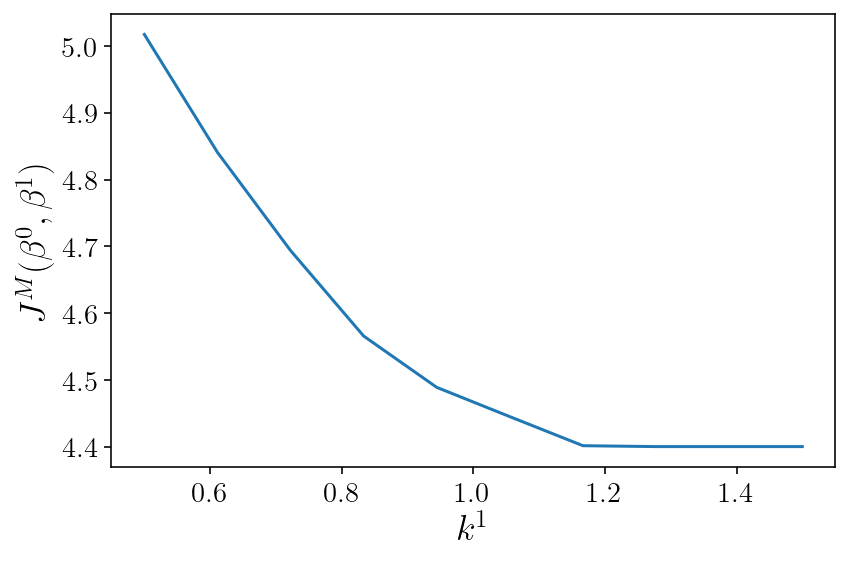

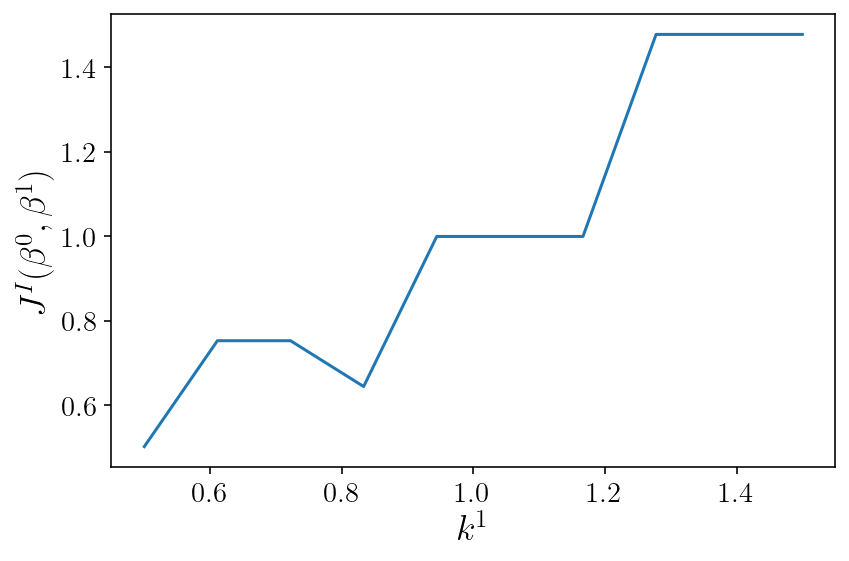

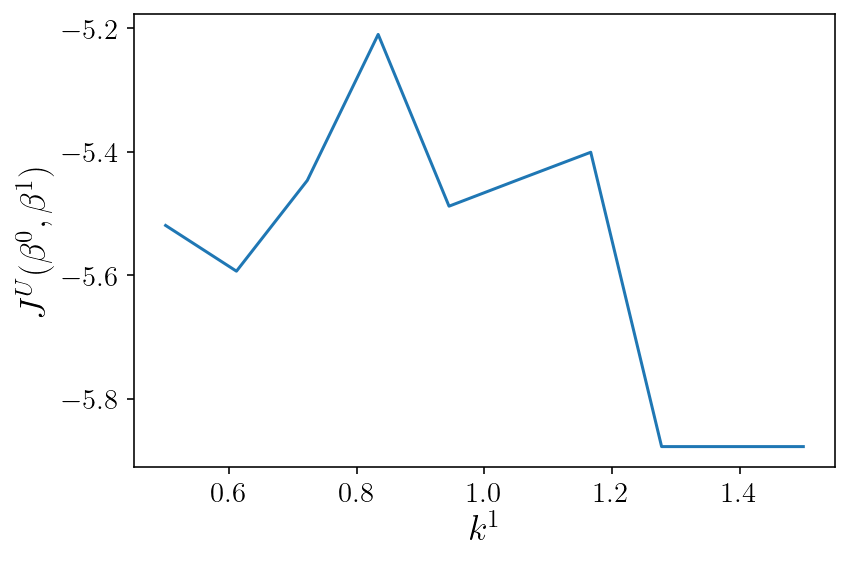

In [62]:
plt.plot(x_m,y_m)
plt.xlabel(r"$k^1$",fontsize=fsL)
plt.ylabel(r'$J^M(\beta^0,\beta^1)$',fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_mm_k1.pdf",format = "pdf",dpi=dpi)
plt.show()

plt.plot(x_i,y_i)
plt.xlabel(r"$k^1$",fontsize=fsL)
plt.ylabel(r'$J^I(\beta^0,\beta^1)$',fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_it_k1.pdf",format="pdf",dpi=dpi)
plt.show()

plt.plot(x_u,y_u)
plt.xlabel(r"$k^1$",fontsize=fsL)
plt.ylabel(r'$J^U(\beta^0,\beta^1)$',fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_ut_k1.pdf", format="pdf",dpi=dpi)
plt.show()

In [54]:
x_m

[0.5,
 0.6111111111111112,
 0.7222222222222222,
 0.8333333333333333,
 0.9444444444444444,
 1.0555555555555556,
 1.1666666666666665,
 1.2777777777777777,
 1.3888888888888888,
 1.5]

In [55]:
y_m

[5.017527614566669,
 4.841032304795462,
 4.693950430529661,
 4.565896812966157,
 4.489030074380561,
 4.445151559526282,
 4.401667065362459,
 4.400323985990355,
 4.400323985990355,
 4.400323985990355]

In [56]:
y_i

[0.5016945412263184,
 0.7522789772067123,
 0.7522789772067123,
 0.6438625822547392,
 0.9990013527702905,
 0.9990013527702905,
 0.9990013527702905,
 1.4771590134593358,
 1.4771590134593358,
 1.4771590134593358]

In [57]:
y_u

[-5.519222155792987,
 -5.593311282002174,
 -5.446229407736373,
 -5.209759395220896,
 -5.488031427150851,
 -5.444152912296572,
 -5.40066841813275,
 -5.8774829994496915,
 -5.8774829994496915,
 -5.8774829994496915]

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

In [58]:
x_m = np.array([0.5,
 0.6111111111111112,
 0.7222222222222222,
 0.8333333333333333,
 0.9444444444444444,
 1.0555555555555556,
 1.1666666666666665,
 1.2777777777777777,
 1.3888888888888888,
 1.5])
y_m = np.array([5.017527614566669,
 4.841032304795462,
 4.693950430529661,
 4.565896812966157,
 4.489030074380561,
 4.445151559526282,
 4.401667065362459,
 4.400323985990355,
 4.400323985990355,
 4.400323985990355])
y_i = np.array([0.5016945412263184,
 0.7522789772067123,
 0.7522789772067123,
 0.6438625822547392,
 0.9990013527702905,
 0.9990013527702905,
 0.9990013527702905,
 1.4771590134593358,
 1.4771590134593358,
 1.4771590134593358])
y_u = np.array([-5.519222155792987,
 -5.593311282002174,
 -5.446229407736373,
 -5.209759395220896,
 -5.488031427150851,
 -5.444152912296572,
 -5.40066841813275,
 -5.8774829994496915,
 -5.8774829994496915,
 -5.8774829994496915])


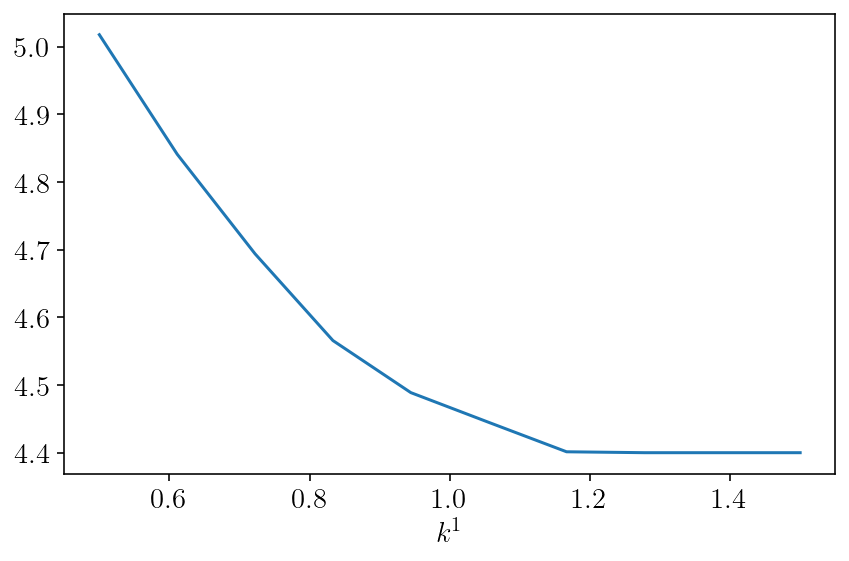

In [59]:
plt.plot(x_m,y_m)
plt.xlabel(r"$k^1$",fontsize=fsL)
plt.ylabel()
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_mm_k1.pdf")

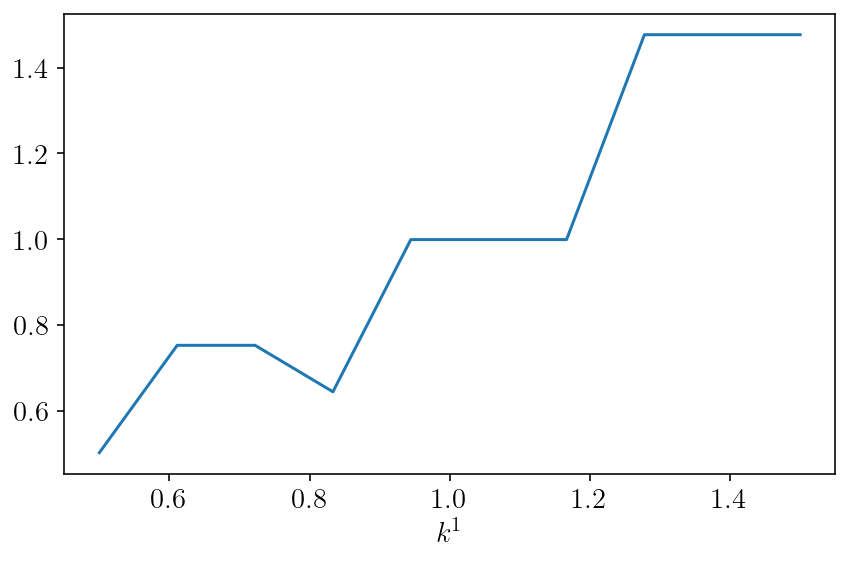

In [60]:
plt.plot(x_m,y_i)
plt.xlabel(r"$k^1$")
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_it_k1.pdf")

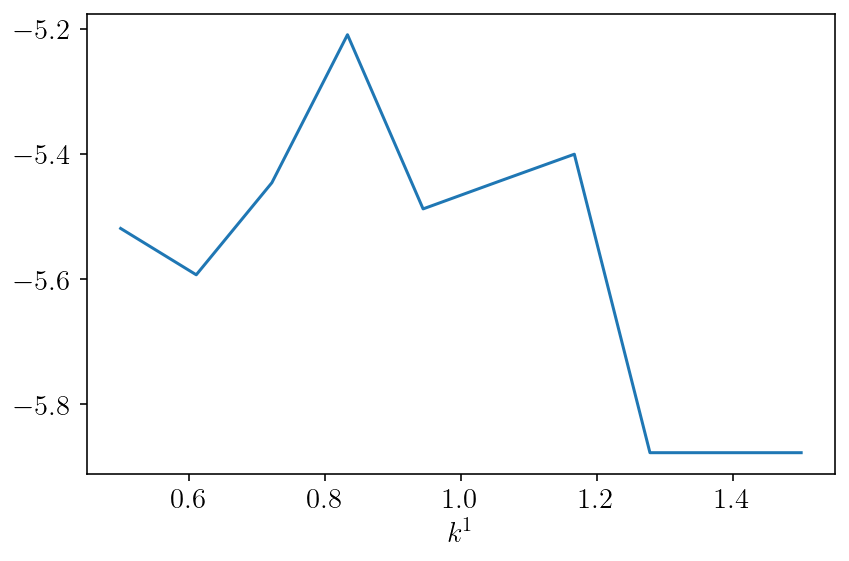

In [61]:
plt.plot(x_m,y_u)
plt.xlabel(r"$k^1$")
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_ut_k1.pdf")

### No signal

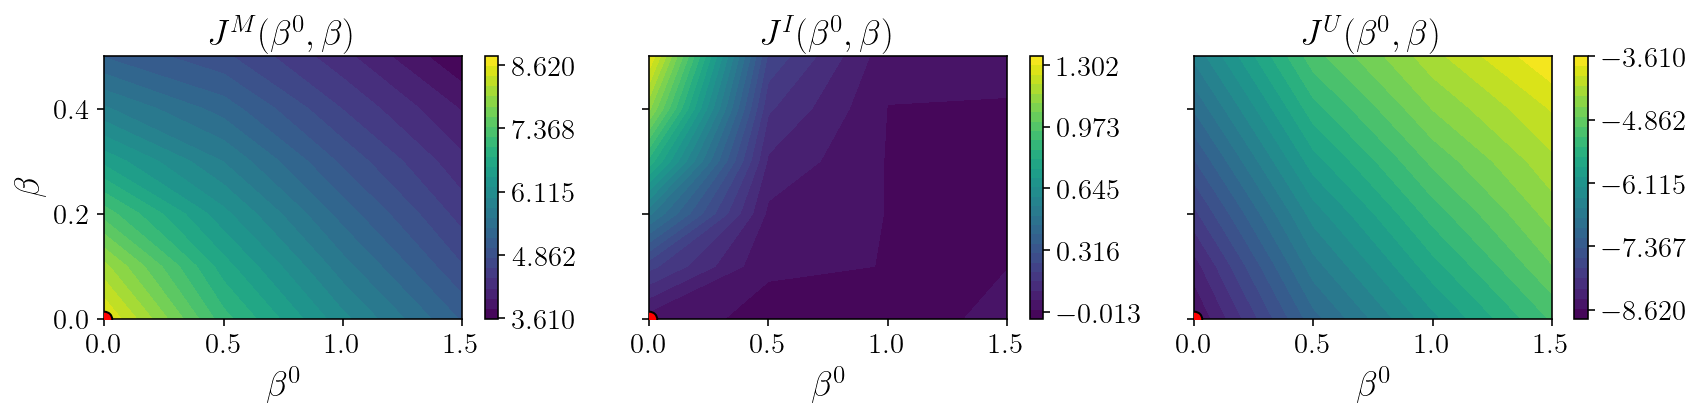

In [11]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = [
    #beta^0, beta,MM,IT,UT
    (0, 0, 8.62,0,-8.62),
    (0,0.1,8.06,0.19,-8.30),
    (0,0.2,7.31,0.52,-7.86),
    (0,0.3,6.54,0.84,-7.42),
    (0,0.4,5.83,1.12,-6.98),
    (0,0.5,5.18,1.34,-6.55),
    
    (0.5,0,7.08,0,-7.08),
    (0.5,0.1,6.69,0,-6.69),
    (0.5,0.2,6.26,0.03,-6.31),
    (0.5,0.3,5.79,0.09,-5.89),
    (0.5,0.4,5.31,0.16,-5.48),
    (0.5,0.5,4.84,0.22,-5.08),
    
    (1,0,6.06,0,-6.06),
    (1,0.1,5.68,0,-5.68),
    (1,0.2,5.31,0,-5.31),
    (1,0.3,4.95,0,-4.95),
    (1,0.4,4.59,0,-4.59),
    (1,0.5,4.26,0.01,-4.27),
    
    (1.5,0,5.17,0.0,-5.17),
    (1.5,0.1,4.81,0.0,-4.81),
    (1.5,0.2,4.51,0.0,-4.51),
    (1.5,0.3,4.25,0.0,-4.25),
    (1.5,0.4,3.98,0.0,-3.98),
    (1.5,0.5,3.61,0.0,-3.61)
]

df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader","PnL_UninformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric', smooth=0.1)
rbf_ut = Rbf(df["beta0"], df["beta"], df["PnL_UninformedTrader"], function='multiquadric')


PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)
PnL_UT_full = rbf_ut(B0_grid, B_grid)


# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten(),
    "PnL_UninformedTrader": PnL_UT_full.flatten()

})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
idx_max_ut = df["PnL_UninformedTrader"].idxmax()

max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_mm, ["beta0", "beta", "PnL_InformedTrader"]]
max_ut = df.loc[idx_max_mm, ["beta0", "beta", "PnL_UninformedTrader"]]


# --- 6. Plot ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=30, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, zorder=5,edgecolors="black")
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title(r"$J^M(\beta^0,\beta)$",fontsize=fsL)
axes[0].set_xlabel(r"$\beta^0$",fontsize=fsL)
axes[0].set_ylabel(r"$\beta$",fontsize=fsL)
cbar=fig.colorbar(c1, ax=axes[0])
cbar.set_ticks(np.linspace(PnL_MM_full.min(), PnL_MM_full.max(), 5))


# PnL Informed Trader
c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=30, cmap="viridis")
axes[1].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, zorder=5,edgecolors="black")
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title(r"$J^I(\beta^0,\beta)$",fontsize=fsL)
axes[1].set_xlabel(r"$\beta^0$",fontsize=fsL)
cbar=fig.colorbar(c2, ax=axes[1])
cbar.set_ticks(np.linspace(PnL_IT_full.min(), PnL_IT_full.max(), 5))


c3 = axes[2].contourf(B0_grid, B_grid, PnL_UT_full, levels=30, cmap="viridis")
axes[2].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, zorder=5,edgecolors="black")
axes[2].set_xlim(B0_grid.min(), B0_grid.max())
axes[2].set_ylim(B_grid.min(), B_grid.max())
axes[2].set_title(r"$J^U(\beta^0,\beta)$",fontsize=fsL)
axes[2].set_xlabel(r"$\beta^0$",fontsize=fsL)
cbar=fig.colorbar(c3, ax=axes[2])
cbar.set_ticks(np.linspace(PnL_UT_full.min(), PnL_UT_full.max(), 5))


fig.tight_layout()
plt.savefig("figures_Stackelberg/no_alpha.pdf",format="pdf",dpi=dpi)

### Big signal, $\sigma^\alpha=10$

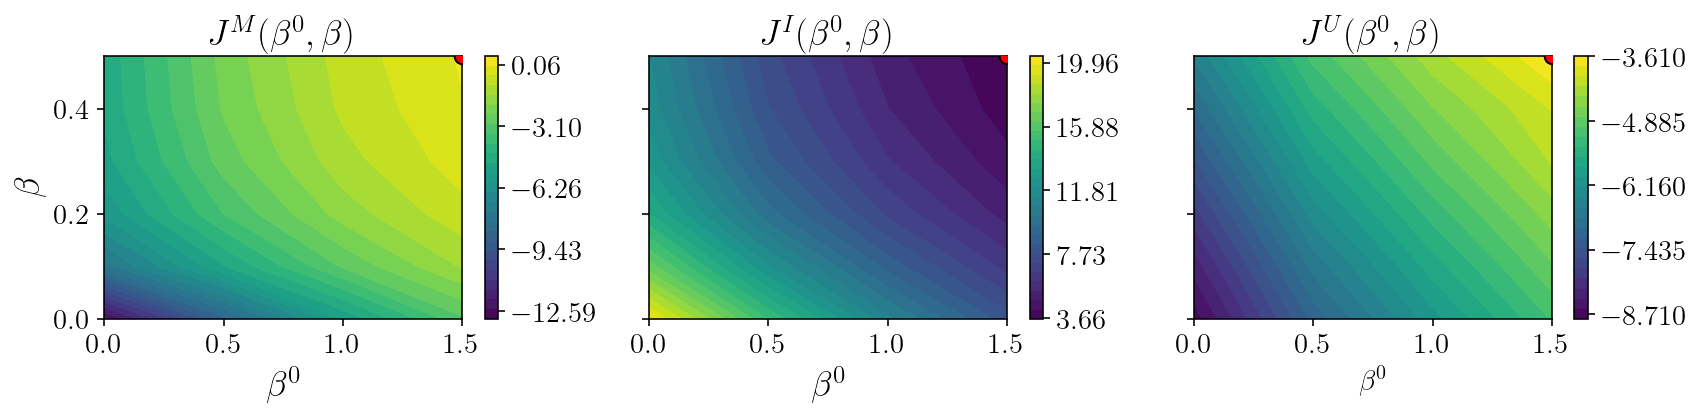

In [21]:
from scipy.interpolate import Rbf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


data = [
    #beta^0, beta,MM,IT,UT
    (0, 0, -12.59,20.76,-8.71),
    (0,0.1,-7.69,15.76,-8.32),
    (0,0.2,-5.86,13.59,-7.88),
    (0,0.3,-5.18,12.49,-7.43),
    (0,0.4,-4.9,11.8,-6.99),
    (0,0.5,-4.85,11.34,-6.57),
    
    (0.5,0,-8.68,15.43,-7.13),
    (0.5,0.1,-5.03,11.58,-6.73),
    (0.5,0.2,-3.49,9.69,-6.31),
    (0.5,0.3,-2.77,8.6,-5.9),
    (0.5,0.4,-2.44,7.89,-5.51),
    (0.5,0.5,-2.31,7.39,-5.13),
    
    (1,0,-5.42,11.25,-6.08),
    (1,0.1,-2.92,8.48,-5.7),
    (1,0.2,-1.77,7.01,-5.32),
    (1,0.3,-1.19,6.09,-4.95),
    (1,0.4,-0.90,5.46,-4.61),
    (1,0.5,-0.77,5.01,-4.28),
    
    (1.5,0,-3.09,8.1,-5.18),
    (1.5,0.1,-1.44,6.18,-4.83),
    (1.5,0.2,-0.66,5.1,-4.5),
    (1.5,0.3,-0.25,4.39,-4.18),
    (1.5,0.4,-0.04,3.90,-3.98),
    (1.5,0.5,0.06,3.53,-3.61)
]

df = pd.DataFrame(data, columns=["beta0", "beta", "PnL_MarketMaker", "PnL_InformedTrader","PnL_UninformedTrader"])

# --- 2. Construire la grille complète des points uniques ---
beta0_vals = np.unique(df["beta0"])
beta_vals  = np.unique(df["beta"])
B0_grid, B_grid = np.meshgrid(beta0_vals, beta_vals)

# --- 3. Interpolation RBF pour remplir les valeurs manquantes ---
rbf_mm = Rbf(df["beta0"], df["beta"], df["PnL_MarketMaker"], function='multiquadric')
rbf_it = Rbf(df["beta0"], df["beta"], df["PnL_InformedTrader"], function='multiquadric', smooth=0.1)
rbf_ut = Rbf(df["beta0"], df["beta"], df["PnL_UninformedTrader"], function='multiquadric')


PnL_MM_full = rbf_mm(B0_grid, B_grid)
PnL_IT_full = rbf_it(B0_grid, B_grid)
PnL_UT_full = rbf_ut(B0_grid, B_grid)


# --- 4. Construire le DataFrame complet interpolé ---
df_full = pd.DataFrame({
    "beta0": B0_grid.flatten(),
    "beta": B_grid.flatten(),
    "PnL_MarketMaker": PnL_MM_full.flatten(),
    "PnL_InformedTrader": PnL_IT_full.flatten(),
    "PnL_UninformedTrader": PnL_UT_full.flatten()

})

# --- 5. Trouver les maxima dans les données brutes pour le point rouge ---
idx_max_mm = df["PnL_MarketMaker"].idxmax()
idx_max_it = df["PnL_InformedTrader"].idxmax()
idx_max_ut = df["PnL_UninformedTrader"].idxmax()

max_mm = df.loc[idx_max_mm, ["beta0", "beta", "PnL_MarketMaker"]]
max_it = df.loc[idx_max_mm, ["beta0", "beta", "PnL_InformedTrader"]]
max_ut = df.loc[idx_max_mm, ["beta0", "beta", "PnL_UninformedTrader"]]


# --- 6. Plot ---
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# PnL Market Maker
c1 = axes[0].contourf(B0_grid, B_grid, PnL_MM_full, levels=30, cmap="viridis")
axes[0].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, zorder=5,edgecolors="black")
axes[0].set_xlim(B0_grid.min(), B0_grid.max())
axes[0].set_ylim(B_grid.min(), B_grid.max())
axes[0].set_title(r"$J^M(\beta^0,\beta)$",fontsize=fsL)
axes[0].set_xlabel(r"$\beta^0$",fontsize=fsL)
axes[0].set_ylabel(r"$\beta$",fontsize=fsL)
cbar = fig.colorbar(c1, ax=axes[0])
cbar.set_ticks(np.linspace(PnL_MM_full.min(), PnL_MM_full.max(), 5))


c2 = axes[1].contourf(B0_grid, B_grid, PnL_IT_full, levels=30, cmap="viridis")
axes[1].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, zorder=5,edgecolors="black")
axes[1].set_xlim(B0_grid.min(), B0_grid.max())
axes[1].set_ylim(B_grid.min(), B_grid.max())
axes[1].set_title(r"$J^I(\beta^0,\beta)$",fontsize=fsL)
axes[1].set_xlabel(r"$\beta^0$",fontsize=fsL)
cbar = fig.colorbar(c2, ax=axes[1])
cbar.set_ticks(np.linspace(PnL_IT_full.min(), PnL_IT_full.max(), 5))

c3 = axes[2].contourf(B0_grid, B_grid, PnL_UT_full, levels=30, cmap="viridis")
axes[2].scatter(max_mm["beta0"], max_mm["beta"], color="red", s=60, zorder=5,edgecolors="black")
axes[2].set_xlim(B0_grid.min(), B0_grid.max())
axes[2].set_ylim(B_grid.min(), B_grid.max())
axes[2].set_title(r"$J^U(\beta^0,\beta)$",fontsize=fsL)
axes[2].set_xlabel(r"$\beta^0$")
cbar=fig.colorbar(c3, ax=axes[2])
cbar.set_ticks(np.linspace(PnL_UT_full.min(), PnL_UT_full.max(), 5))

fig.tight_layout()
plt.savefig("figures_Stackelberg/big_alpha.pdf",format="pdf", dpi=dpi)

### Optimal PnL as a function of $k$ for $k^0$ fixed

In [12]:
k_values = np.linspace(0.5,1.5,5)
PnL_mm = np.array([4.9,4.61,4.6,4.6,4.6])
PnL_it= np.array([1.89,1.24,1.44,1.44,1.44])
PnL_ut = np.array([-6.83,-5.88,-6.08,-6.08,-6.08])

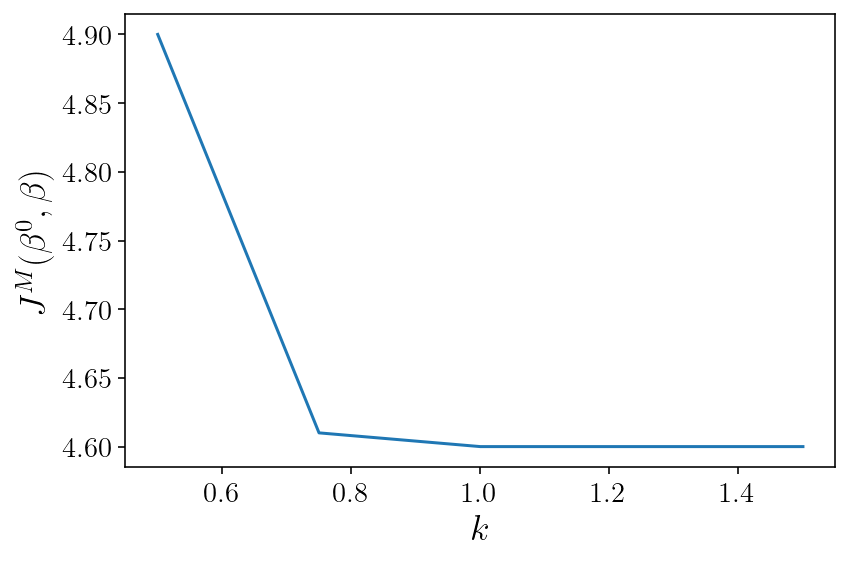

In [16]:
plt.plot(k_values,PnL_mm)
plt.xlabel(r"$k$",fontsize=fsL)
plt.ylabel(r'$J^M(\beta^0,\beta)$',fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_mm_k_beta.pdf")
plt.show()

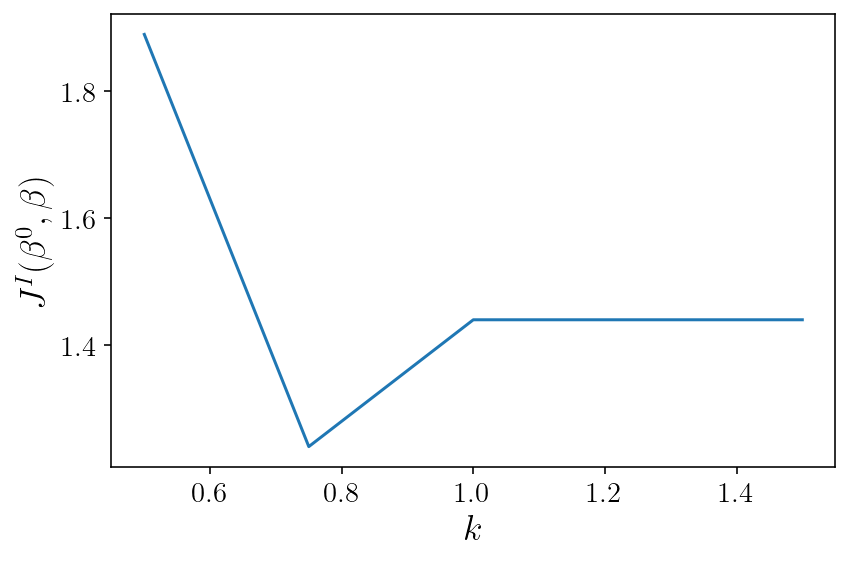

In [17]:
plt.plot(k_values,PnL_it)
plt.xlabel(r"$k$",fontsize=fsL)
plt.ylabel(r'$J^I(\beta^0,\beta)$',fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_it_k_beta.pdf")
plt.show()

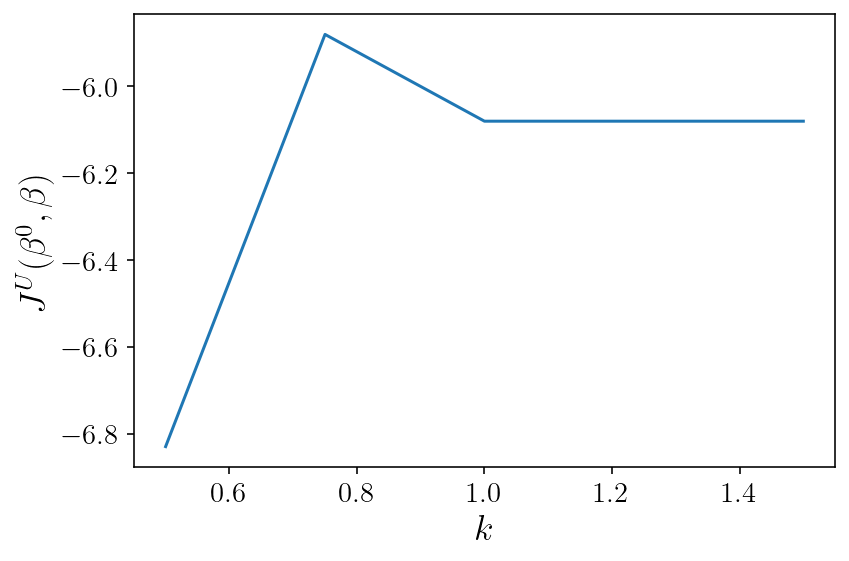

In [18]:
plt.plot(k_values,PnL_ut)
plt.xlabel(r"$k$",fontsize=fsL)
plt.ylabel(r'$J^U(\beta^0,\beta)$',fontsize=fsL)
plt.tight_layout()
plt.savefig("figures_Stackelberg/optPnL_ut_k_beta.pdf")
plt.show()